# 国勢調査の結果をグラフにしてみる。
2020年(令和2年) 10月 の国勢調査の結果から人口分布のグラフを作成してみます。
必要なデータは

https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00200521&tstat=000001136464&cycle=0&year=20200&month=24101210&tclass1=000001136466&tclass2val=0

からダウンロードします。ここで使うのは、「2-1　男女，年齢（各歳），国籍総数か日本人別人口，平均年齢及び年齢中位数－全国，都道府県，21大都市，特別区，人口50万以上の市」のExcel ファイルです。Excelファイル「b02_01.xlsx」をダウンロードしておきましょう。このExcelファイルから必要なデータを柔軟に引き出すために、sqlite3のデータベースに変換します。sqlite3データベースとすることで、一部のデータを取り出す操作をPythonプログラムの中で柔軟に記述できるようになります。(pandasモジュールのDataFrameでも同様のことはできるかもしれません。sqlalchemyを使うことも考えられますが、ここでの操作ではそこまで複雑な選択をしていないので、sqlite3を使うことにします。 

pandasのread_excel/ to_sql関数を使うことで、この変換は簡単に実現できます。
ダウンロードしたExcelファイル(b02_01.xlsx)の中身をチェックすると、最初の10行には、追加的な情報が書き込まれており、11行目から実際のデータが始まります。
また、11行の第五列から百二十八列には、第9行の項目名をコピーしておきます。
(最初からそうしておいてくれるといいのにと思います）

外部から入手したExcelファイルをPythonで読み込んで処理するためには、このような一手間が必要だと覚悟した方が良いでしょう。ただ、一回手間をかけておけば、後の作業はスムースです。

In [1]:
import pandas
import sqlite3

df=pandas.read_excel("b02_01.xlsx",skiprows=10)
fields=df.columns
# 人口総数と1歳ごとの人口のフィールド名を取り出しておきます。
fld_total=fields[4]
fld_ages=fields[5:-9]
# ラベルとして使うために、列名からコード部分を取り除いておきます。
lbl_ages=[l.split("_")[1] for l in fld_ages]
#lbl_ages

人口のデータ(第五列から百二十四列まで）は整数として読み込むべきですが、なんらかの(よくわからない）理由でTEXTと認識されてしまうことがあります。ここでは、これらの列については、INTEGERが入ることを明示的に指定します。
これには、:py:func:`to_sql` の `dtype` 引数に列名とDBデータとしての型からなる辞書を指定しておきます。

In [2]:
with sqlite3.connect("b02_01.db") as con:
  df.to_sql("population",con=con,if_exists="replace",schema="CENSUS",
            dtype=dict(((k, "INTEGER") for k in fields[5:-2])), 
  )

全国の人口データは後で何度も使うので、専用のクラスを作っておきます。

In [3]:
class JPN_Population(object):
  
  def __init__(self):
    with sqlite3.connect("b02_01.db") as con:
      q=con.execute("select * from population where 国籍総数か日本人 = '0_国籍総数' and 地域名 = '00000_全国'")
      self.total, self.male, self.female=q.fetchall()

  @property
  def population_total(self):
    return self.total[5:-9]

  @property
  def population_male(self):
    return self.male[5:-9]

  @property
  def population_female(self):
    return self.female[5:-9]

JPN=JPN_Population()

In [4]:
with sqlite3.connect("b02_01.db") as con:
  prefectures=[e[0] for e in con.execute("select distinct 地域名 from population where 地域識別コード == 'a' ;").fetchall()]
# prefectures

このデータを使って、Wikipediaの地方自治体の項目でよく表示される年齢別の人口分布のグラフを作成してみましょう。
男女を区別しない総数でのグラフと男女を分けた人口分布のグラフの2種類を各都道府県毎に作成します。

In [5]:
import matplotlib
import matplotlib.pyplot as pyplot
from matplotlib import rcParams
rcParams['font.sans-serif'].insert(0,"IPAexGothic") # for Japanese fonts in titles
rcParams['font.serif'].insert(0,"IPAPMincho") # for Japanese fonts in titles
rcParams['figure.max_open_warning']=48

def draw_graph(areaname):
  """
  arows : result of con.execute("select * from population where 地域名 = <地域名>'")
  """
  with sqlite3.connect("b02_01.db") as con:
    q=con.execute(f"select * from population where 国籍総数か日本人 = '0_国籍総数' and 地域名 = '{areaname}'")
    total, male, female=q.fetchall()
  
  fig,axes=pyplot.subplots(1,2)
  fig.set_size_inches(16,9)
  xlbl=lbl_ages
  xlabels=xlbl[:-2:10]+xlbl[-1:]
  xticks=[xlbl.index(l) for l in xlabels]
  axes[0].set_xticks(xticks, xlabels, rotation=-90)
  axes[1].set_xticks(xticks, xlabels, rotation=-90)
  
  axes[0].plot(
    xlbl, [0 if v=='-' else 100*v/total[5] for v in total[6:-9]],
    label=areaname.split("_")[1],
    ds="steps", color="violet", ls="-")
  axes[0].plot(
    xlbl, [0 if v=='-' else 100*v/JPN.population_total[0] for v in JPN.population_total[1:]],
    label="日本全国",
    ds="steps", color="green",ls=":")
  axes[0].legend()
  
  axes[1].plot(
    xlbl, [0 if v=='-' else 100*v/total[5] for v in male[6:-9] ],
    label="男性",ls="-",
    ds="steps", color="blue")
  axes[1].plot(
    xlbl, [0 if v=='-' else 100*v/total[5] for v in female[6:-9]],
    label="女性",  ls="--", ds="steps", color="red")
  
  axes[1].plot(
    xlbl, [0 if v=='-' else 100*v/JPN.population_total[0] for v in JPN.population_male[1:]],
    label="男性(全国)", ls="-",
    ds="steps", color="cyan")
  
  axes[1].plot(
    xlbl, [0 if v=='-' else 100*v/JPN.population_total[0] for v in JPN.population_female[1:]],
    label="女性(全国)", ls="--",
    ds="steps", color="pink")
  
  pyplot.legend()
  pyplot.draw()

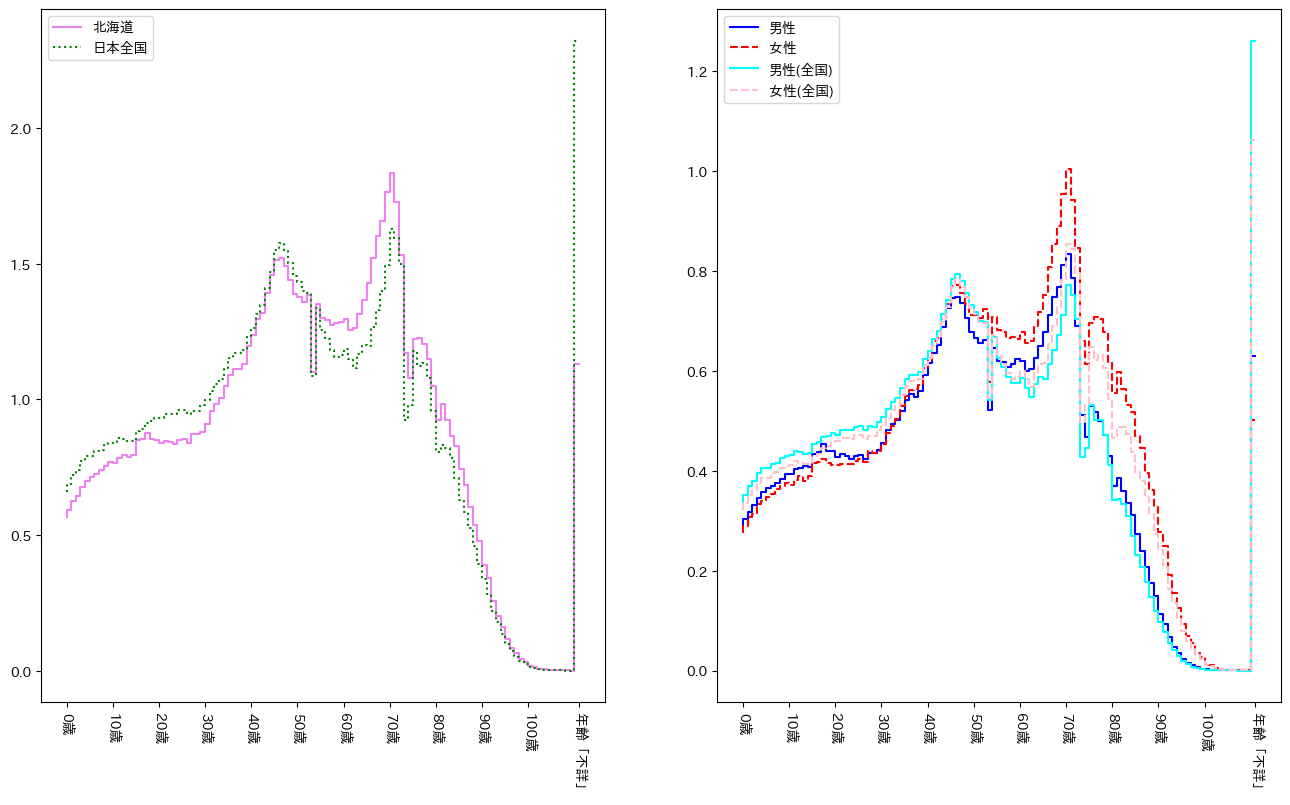

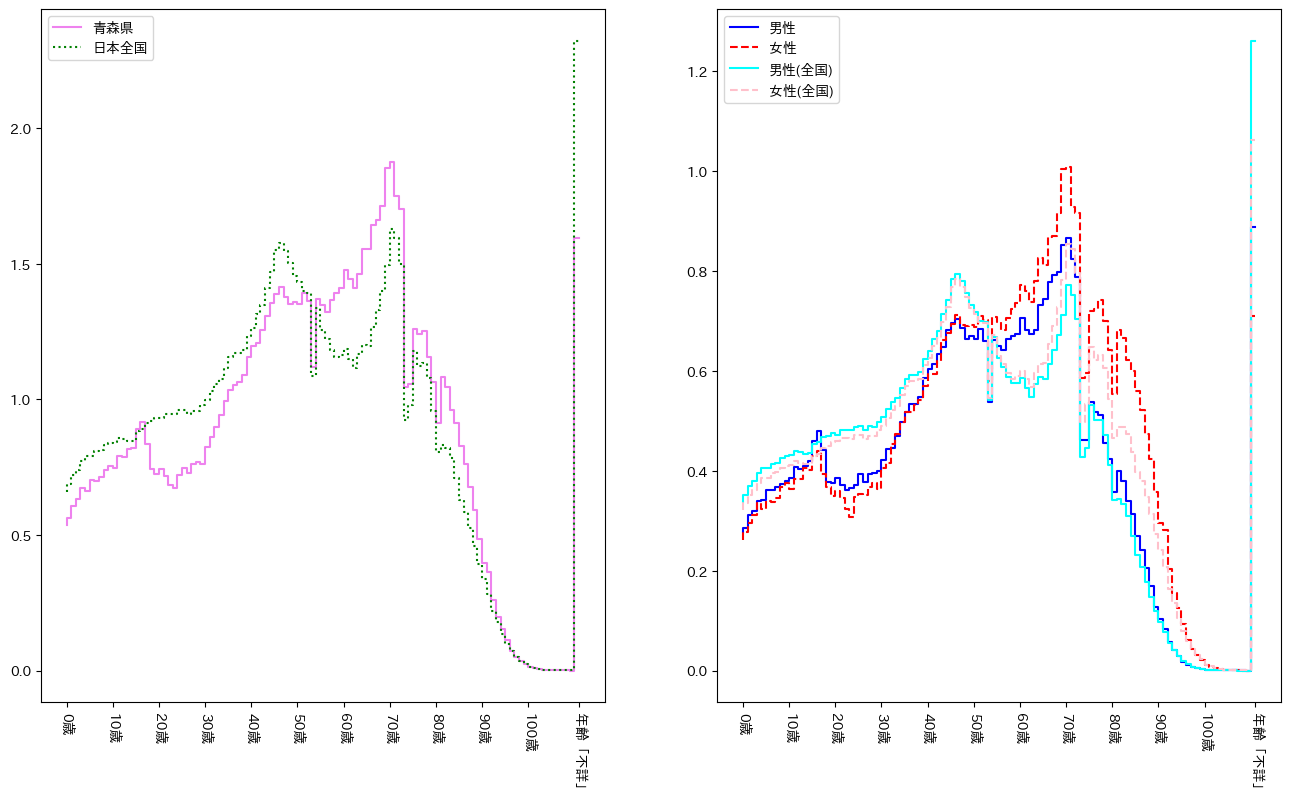

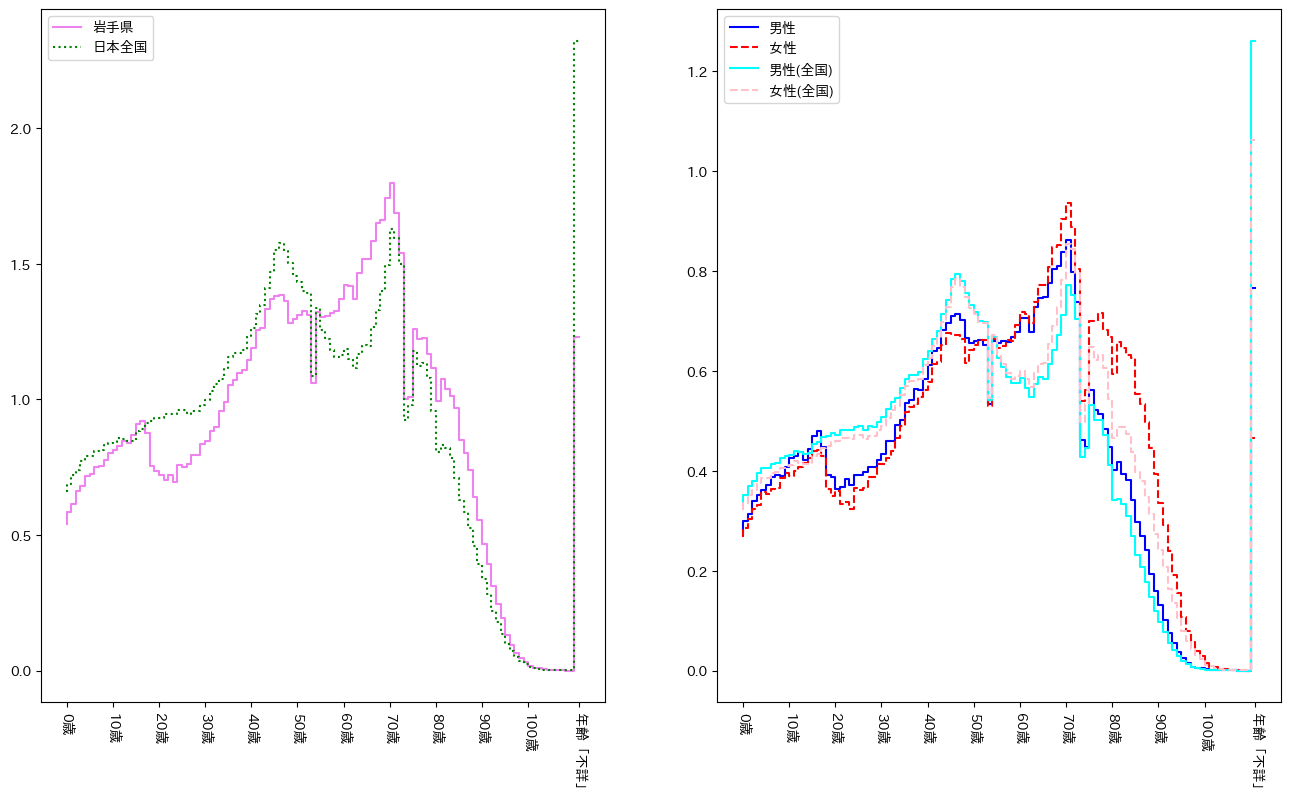

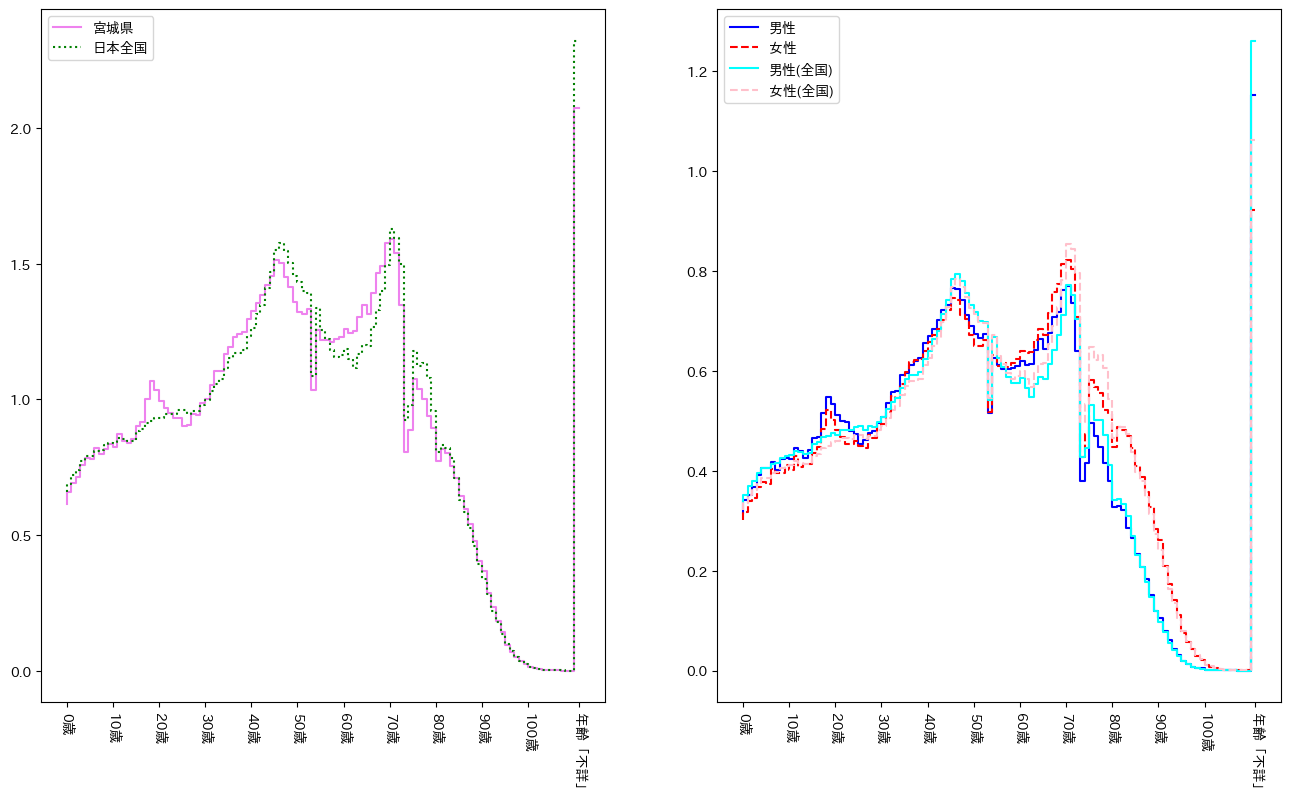

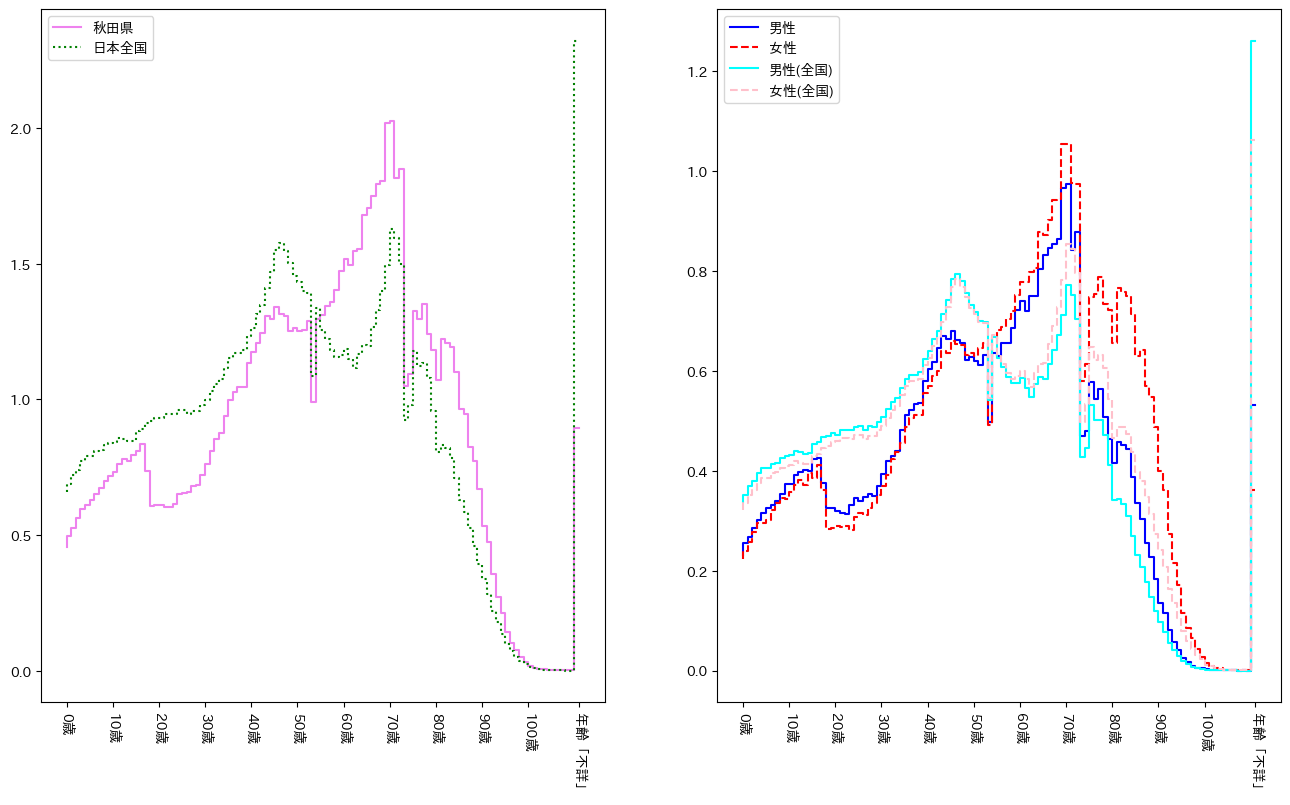

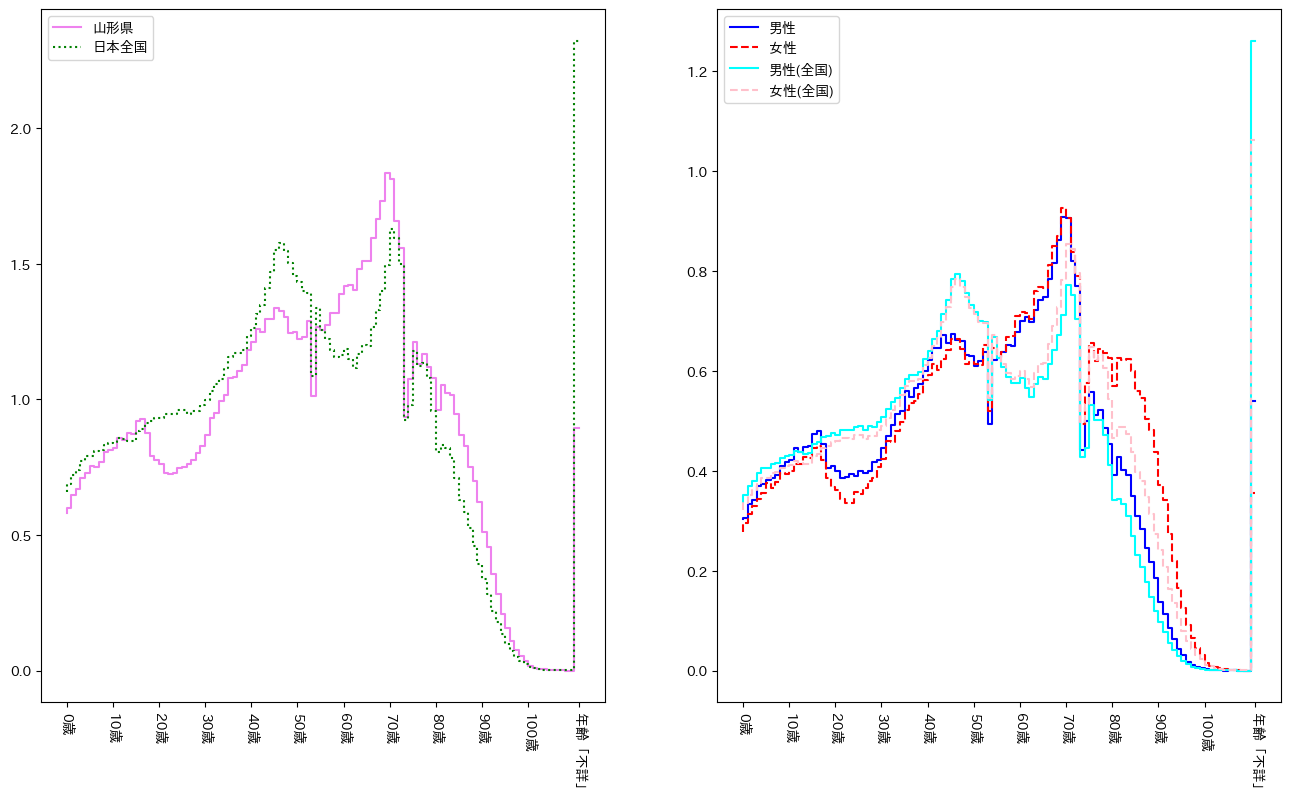

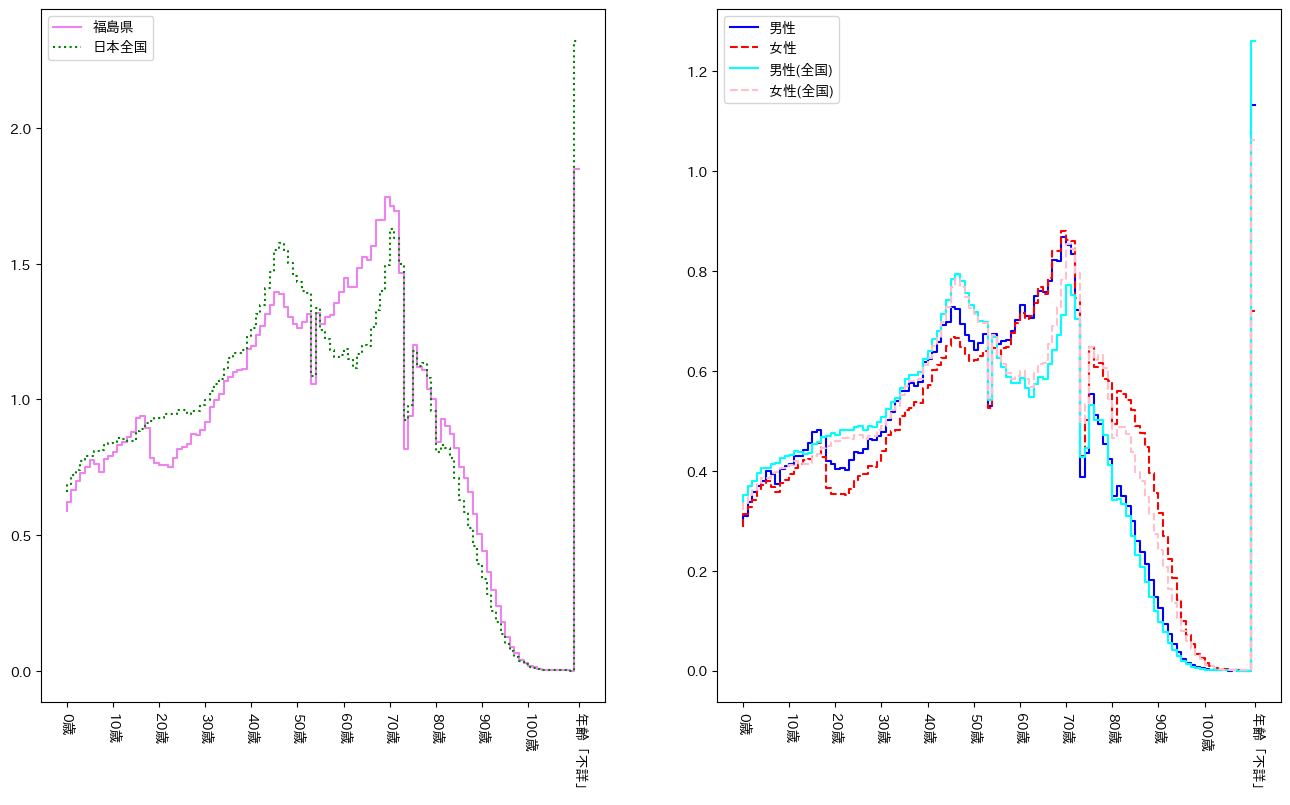

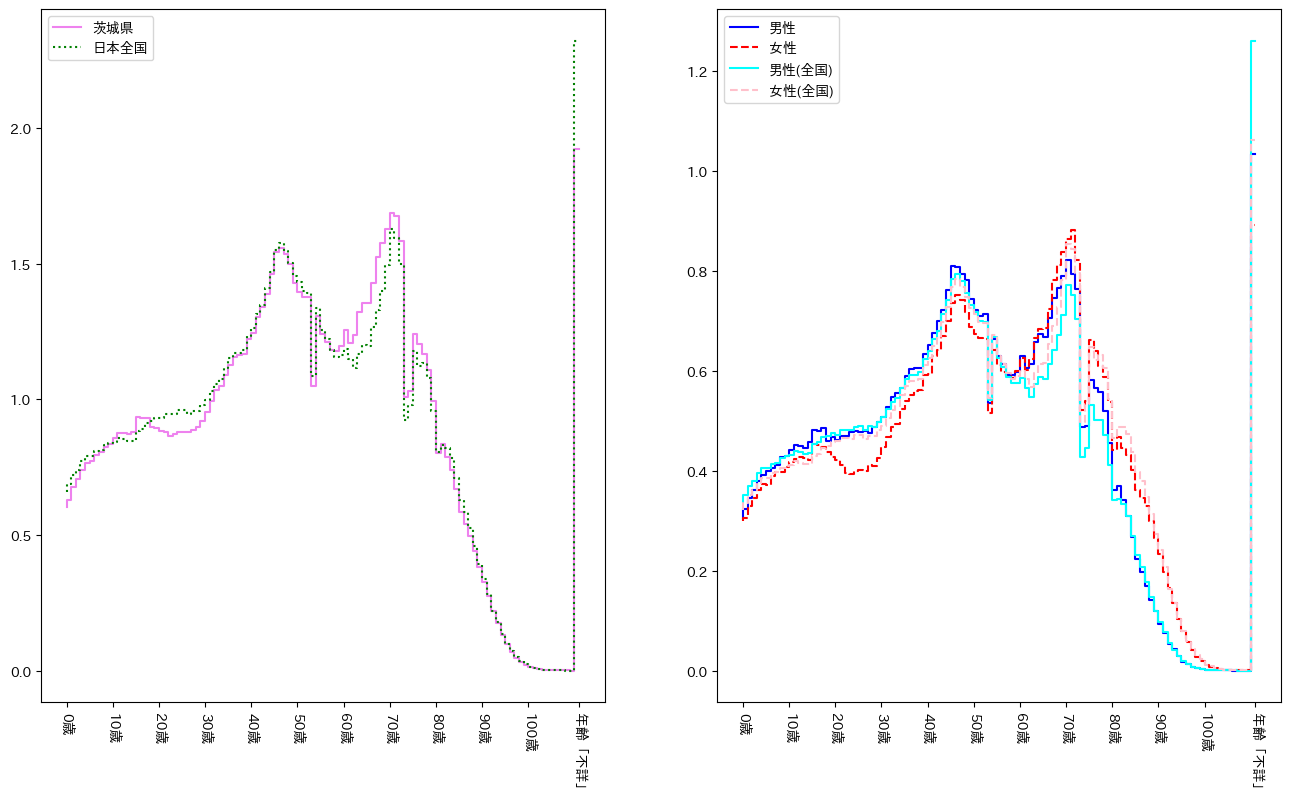

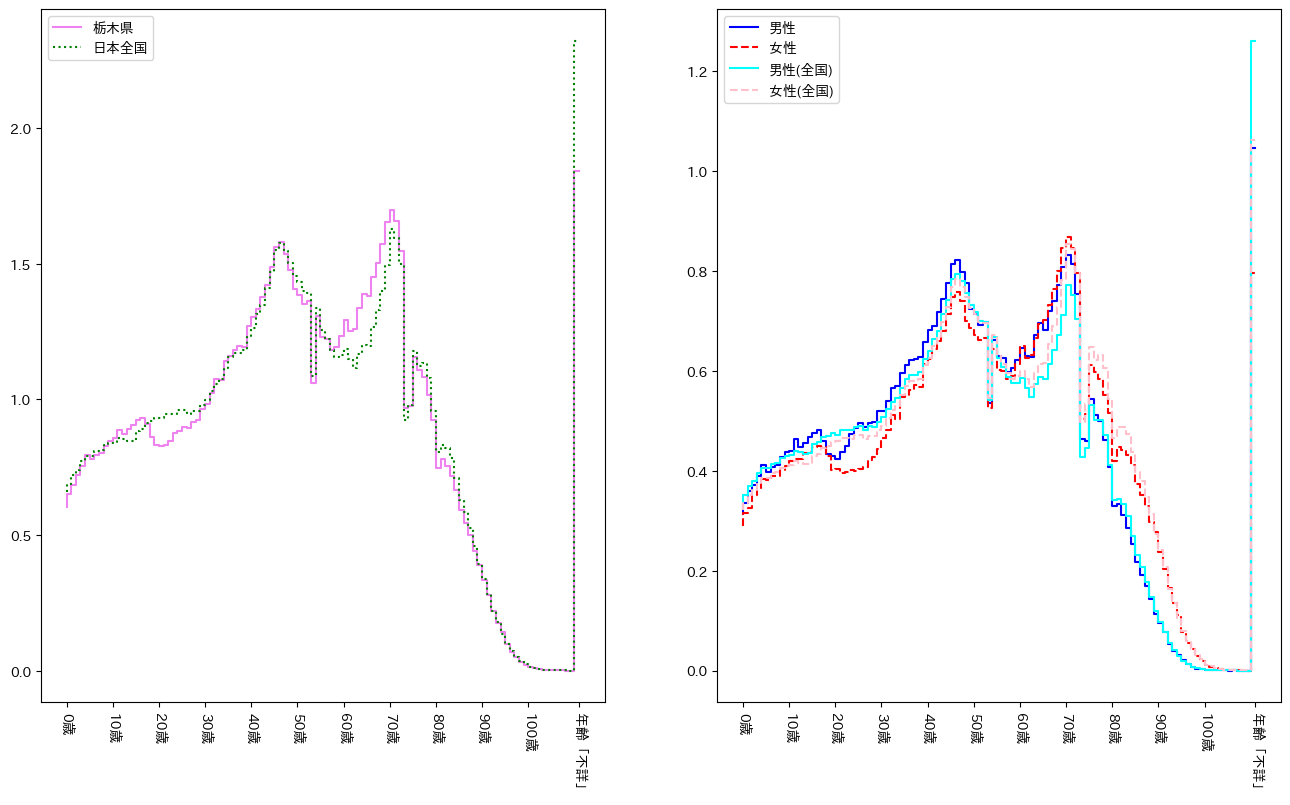

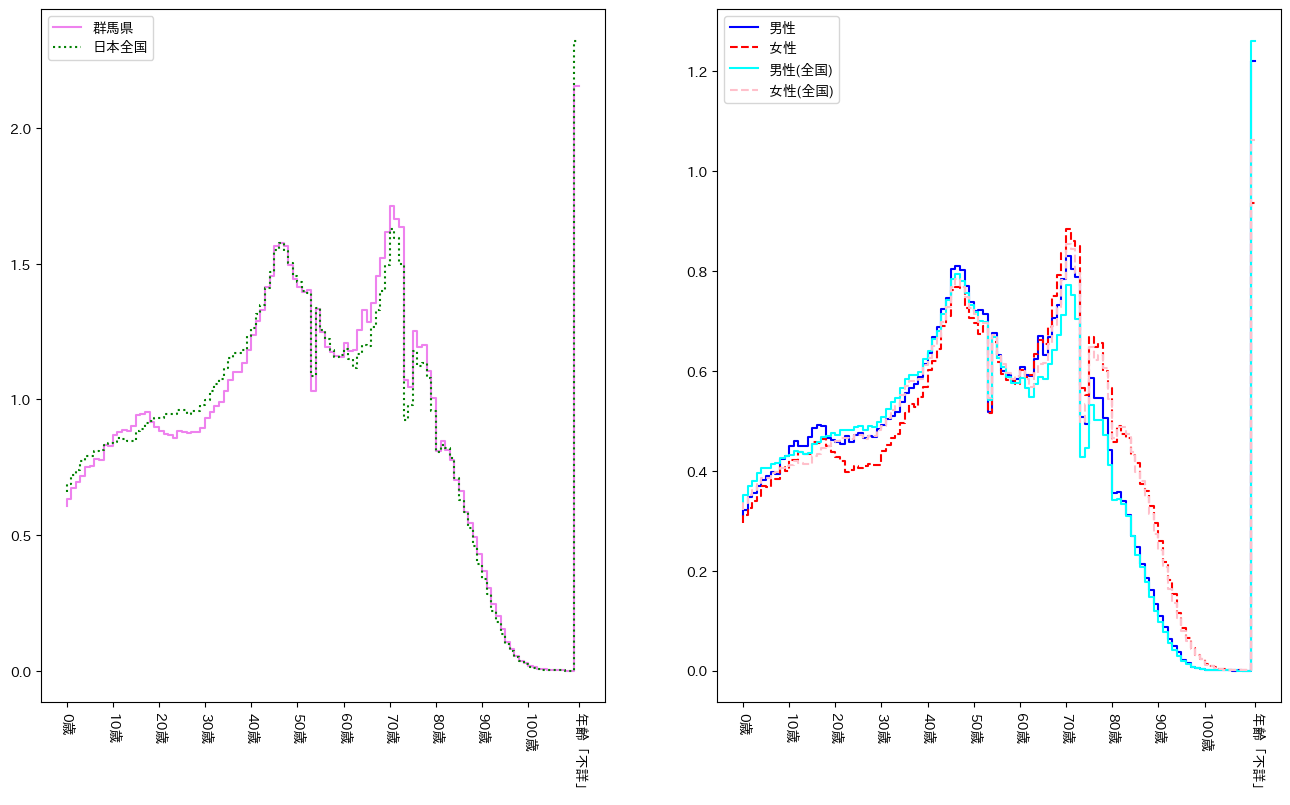

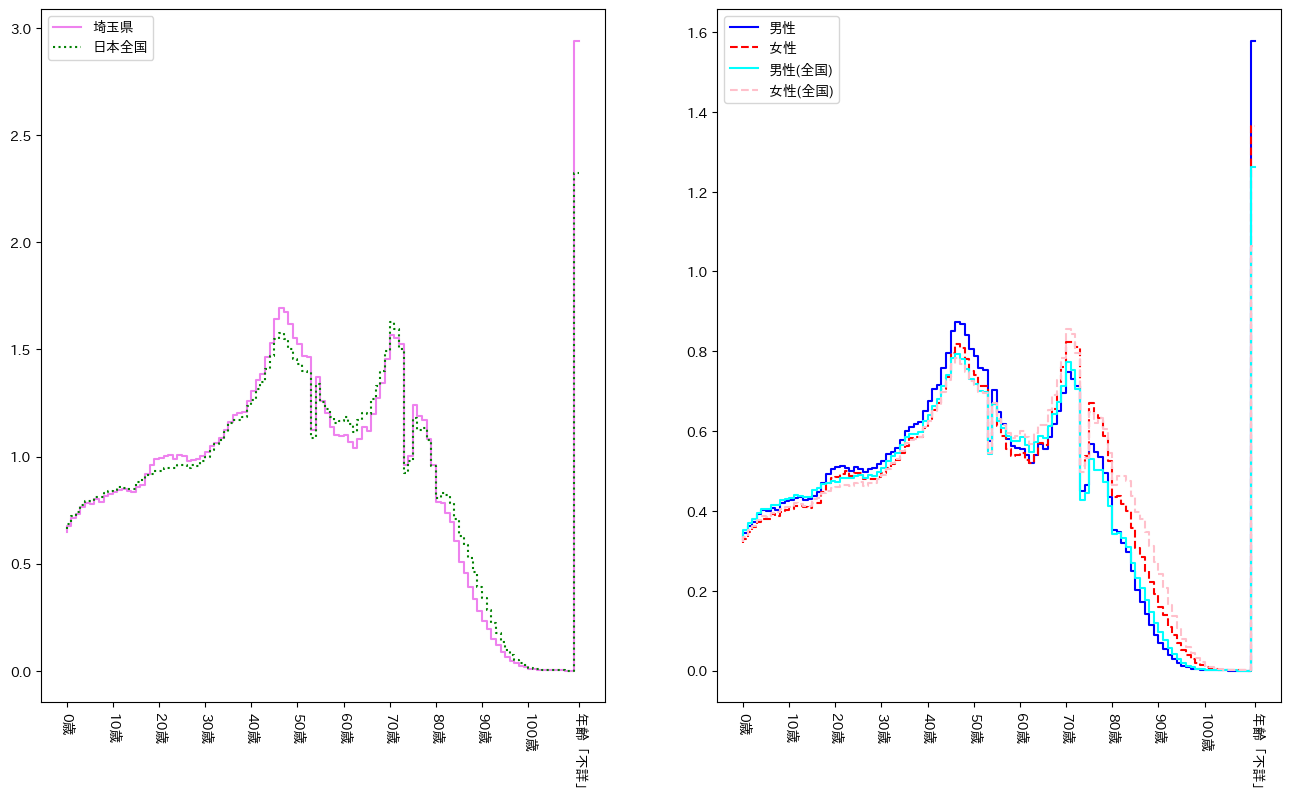

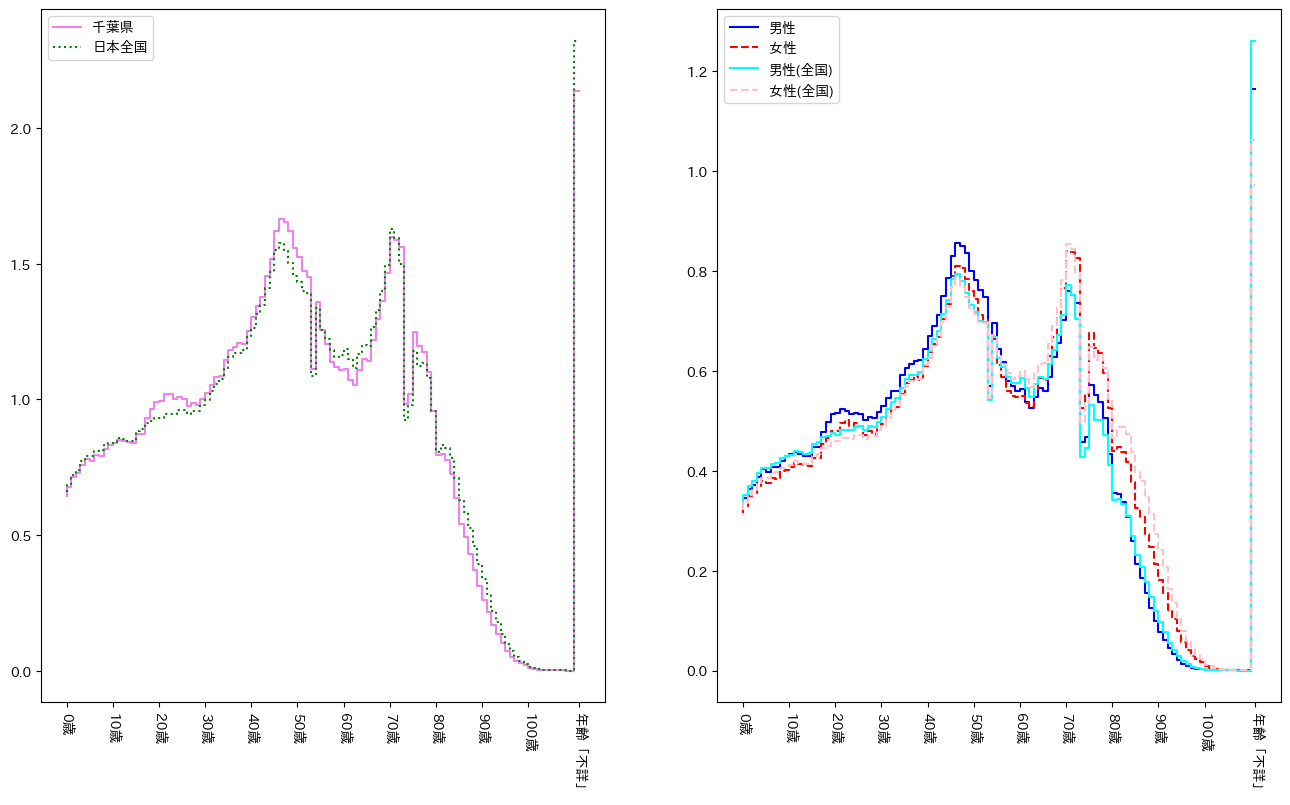

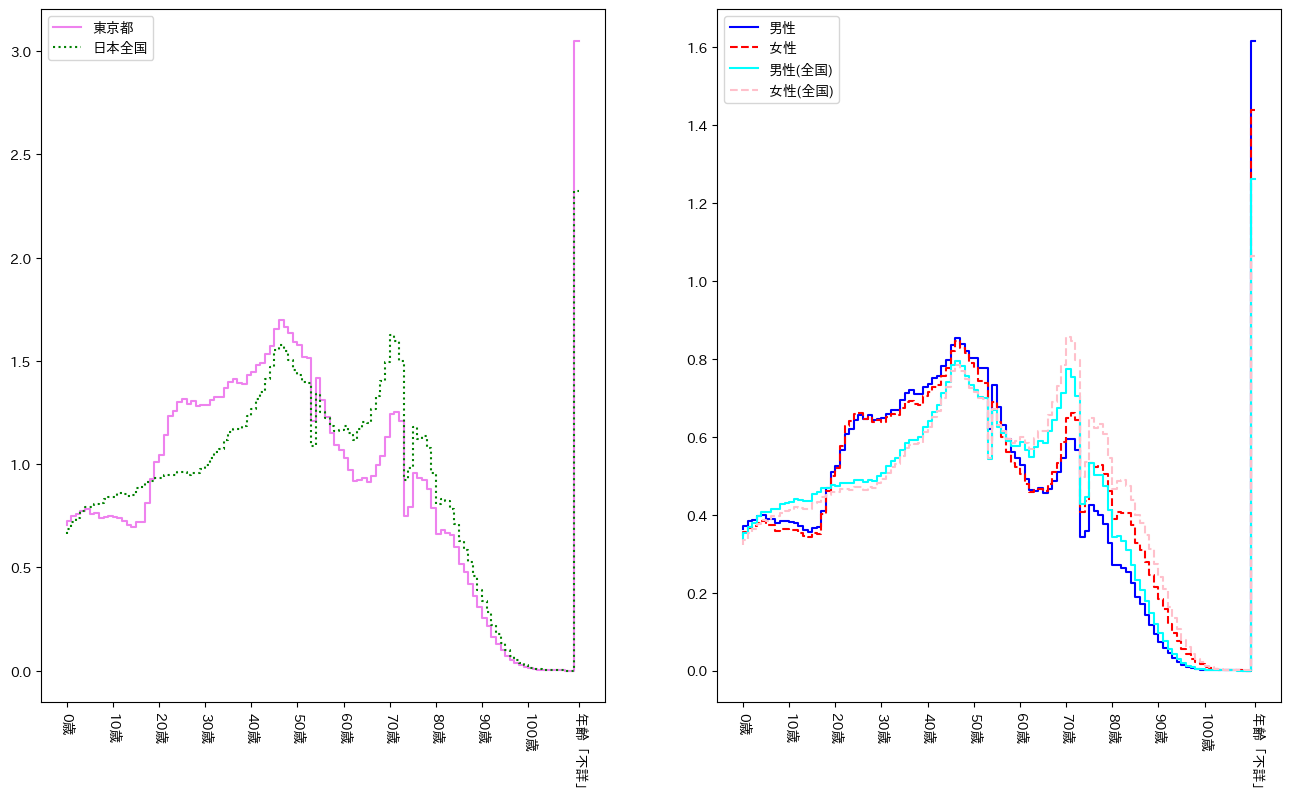

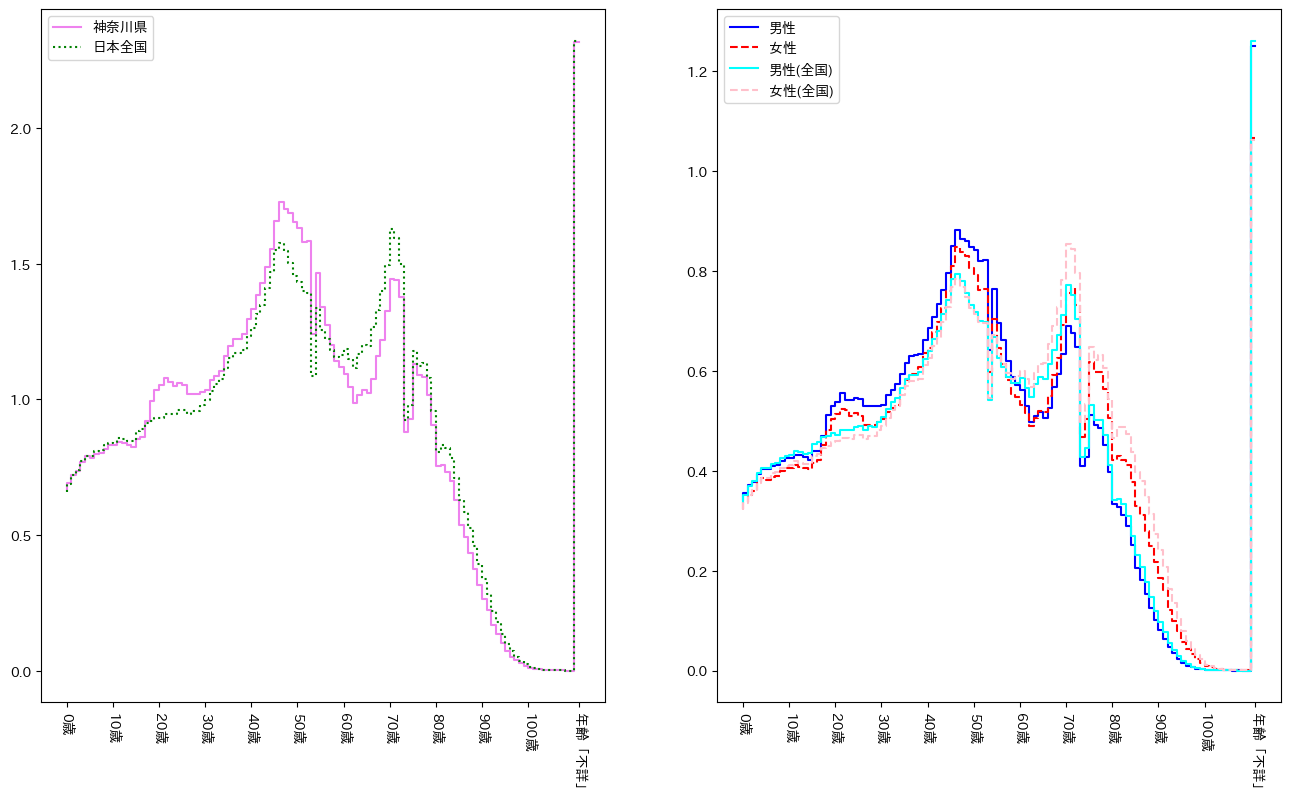

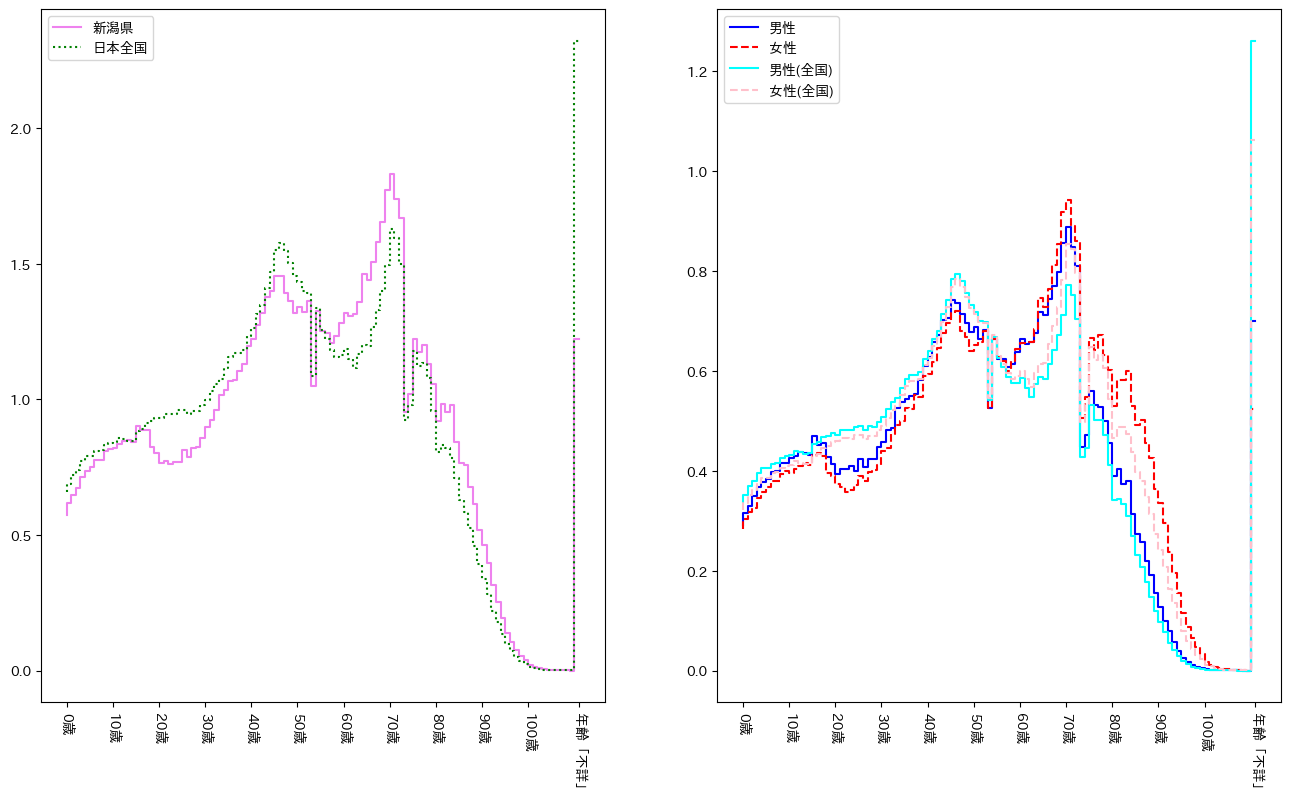

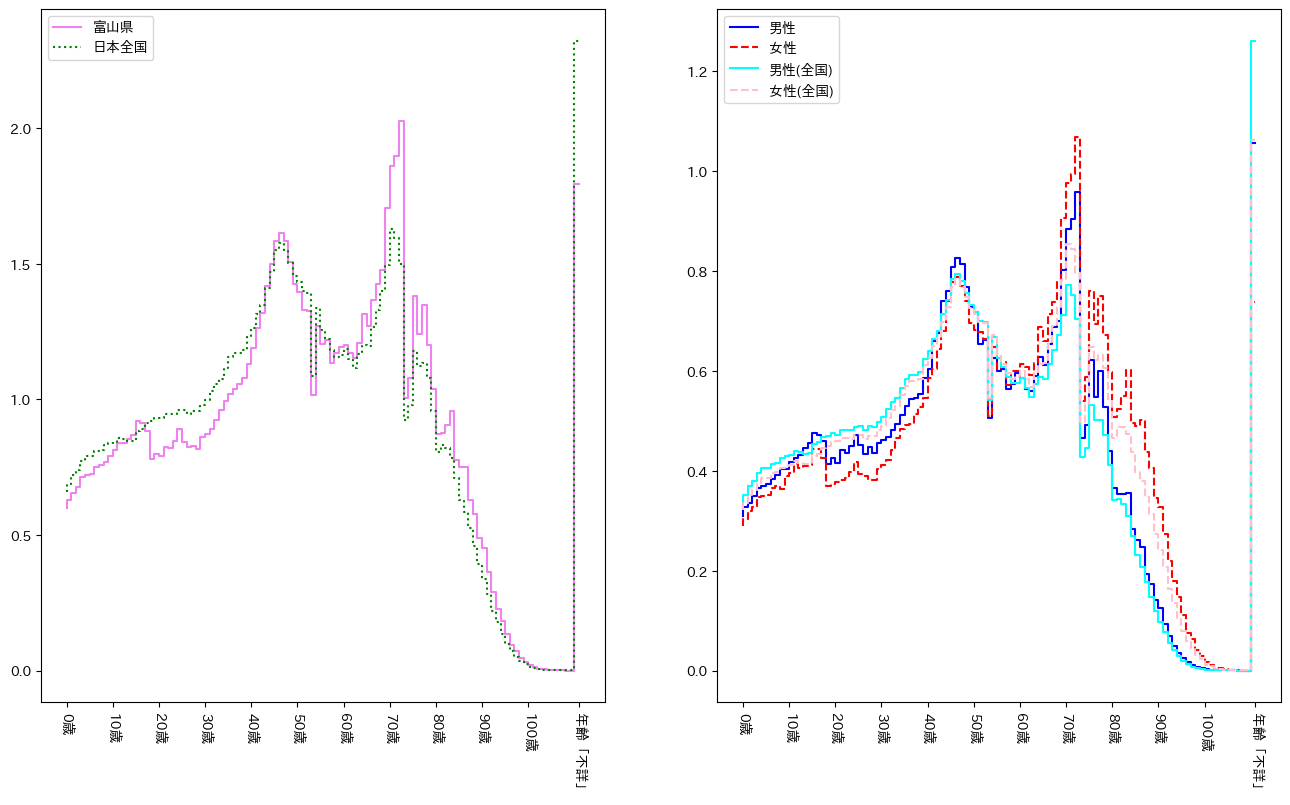

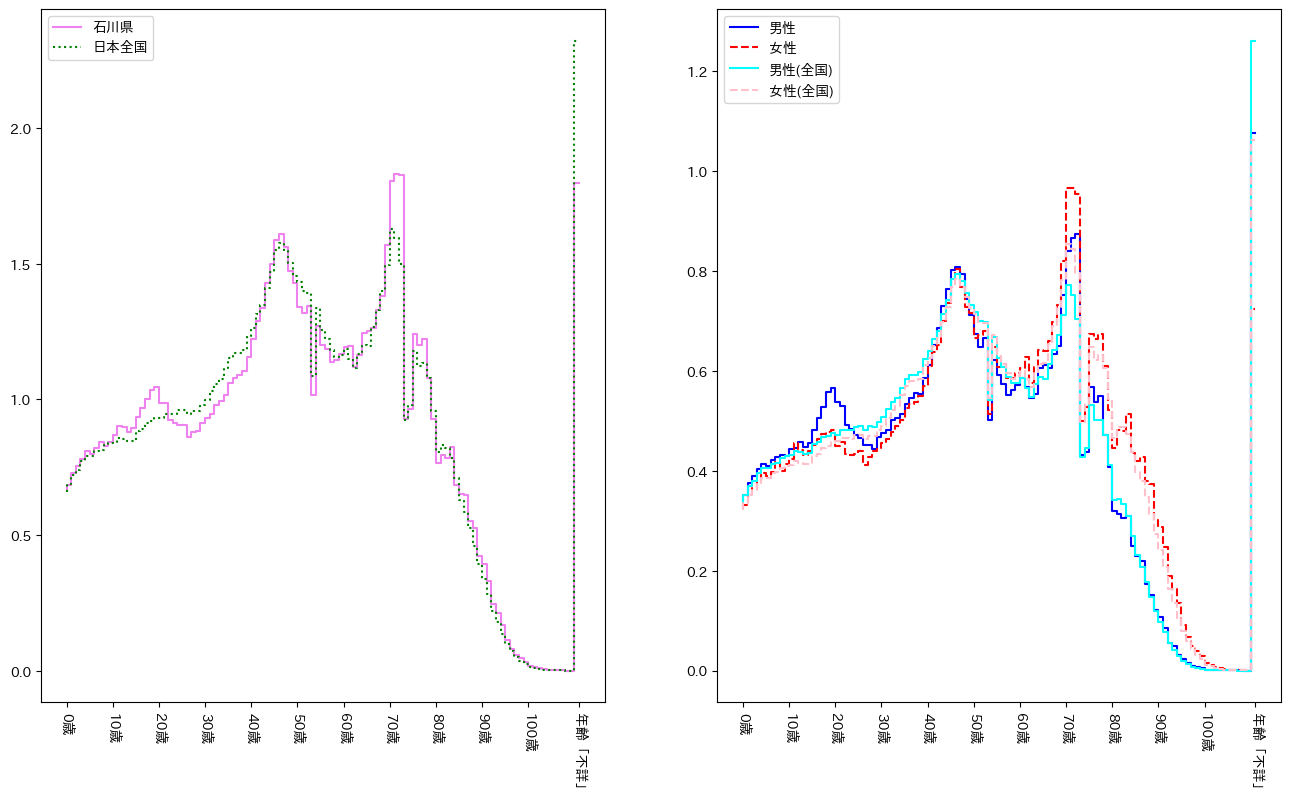

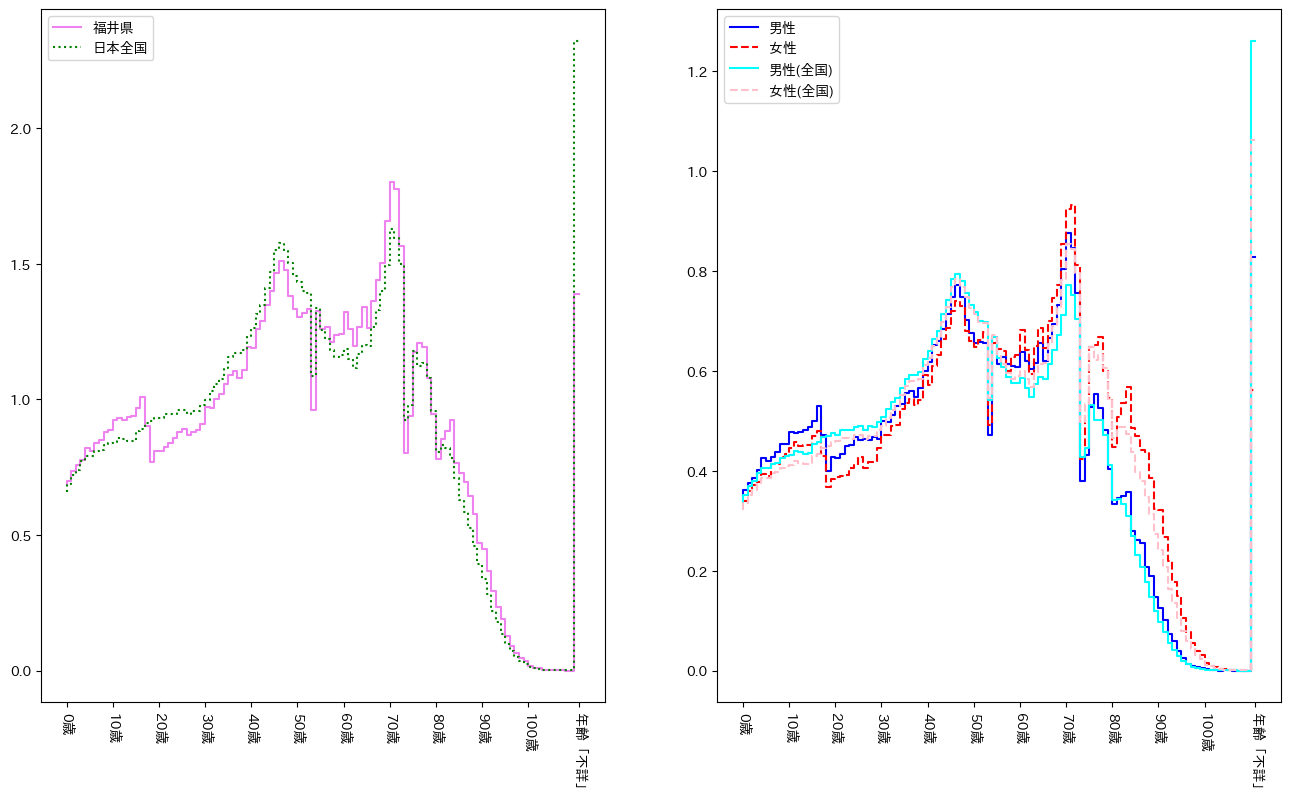

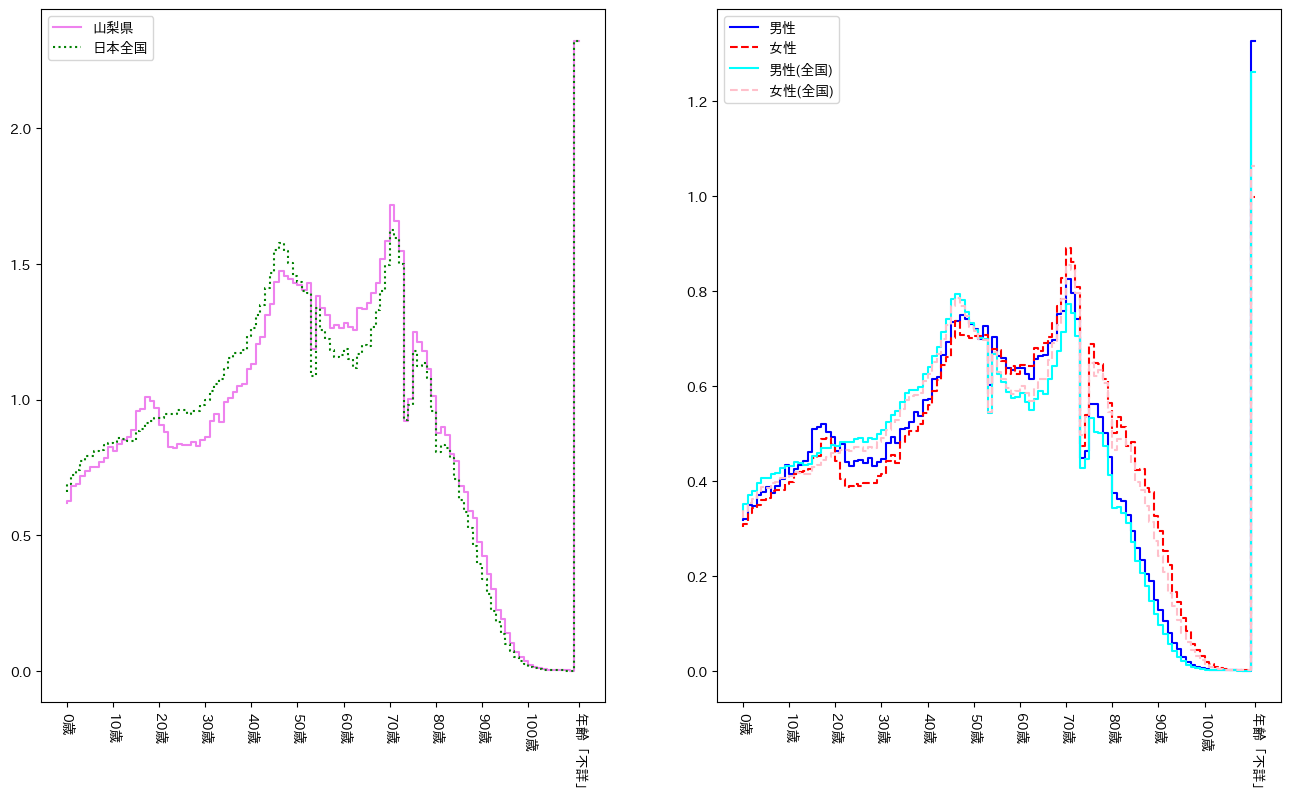

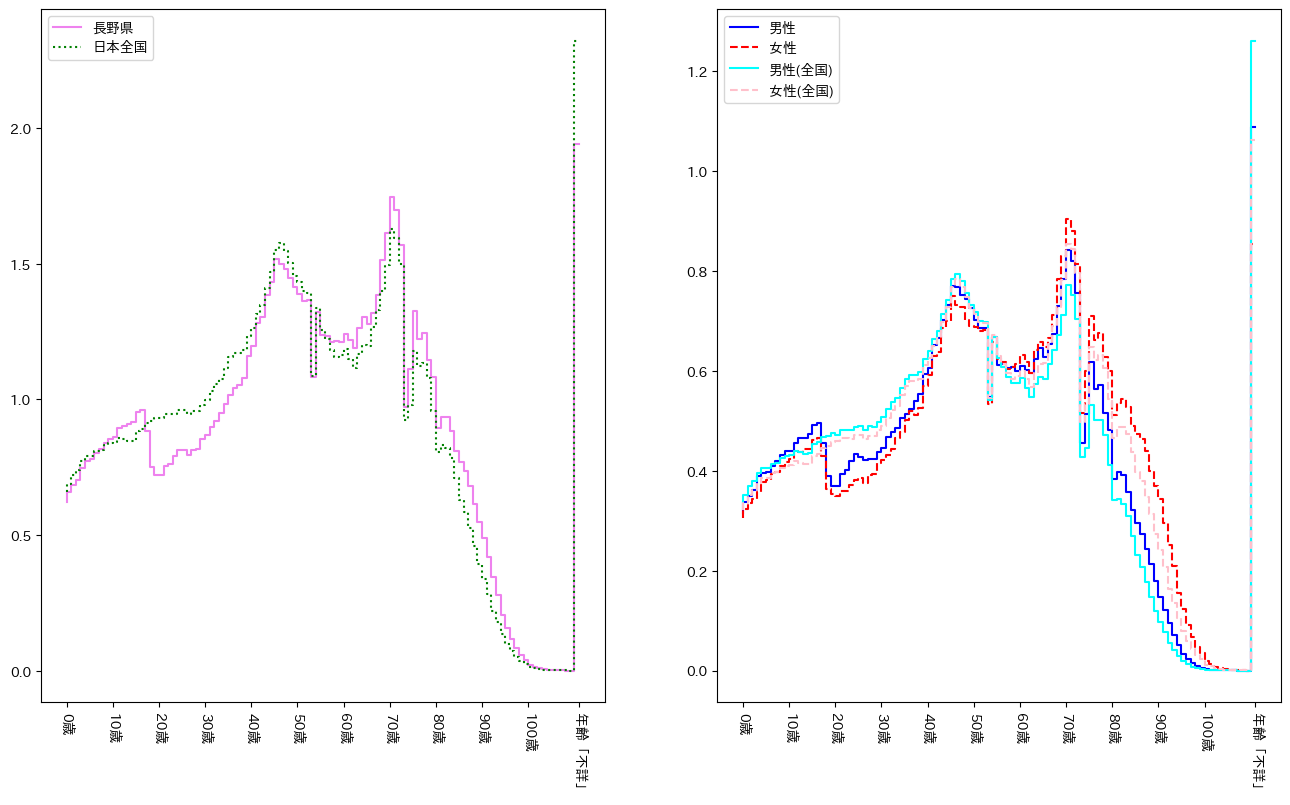

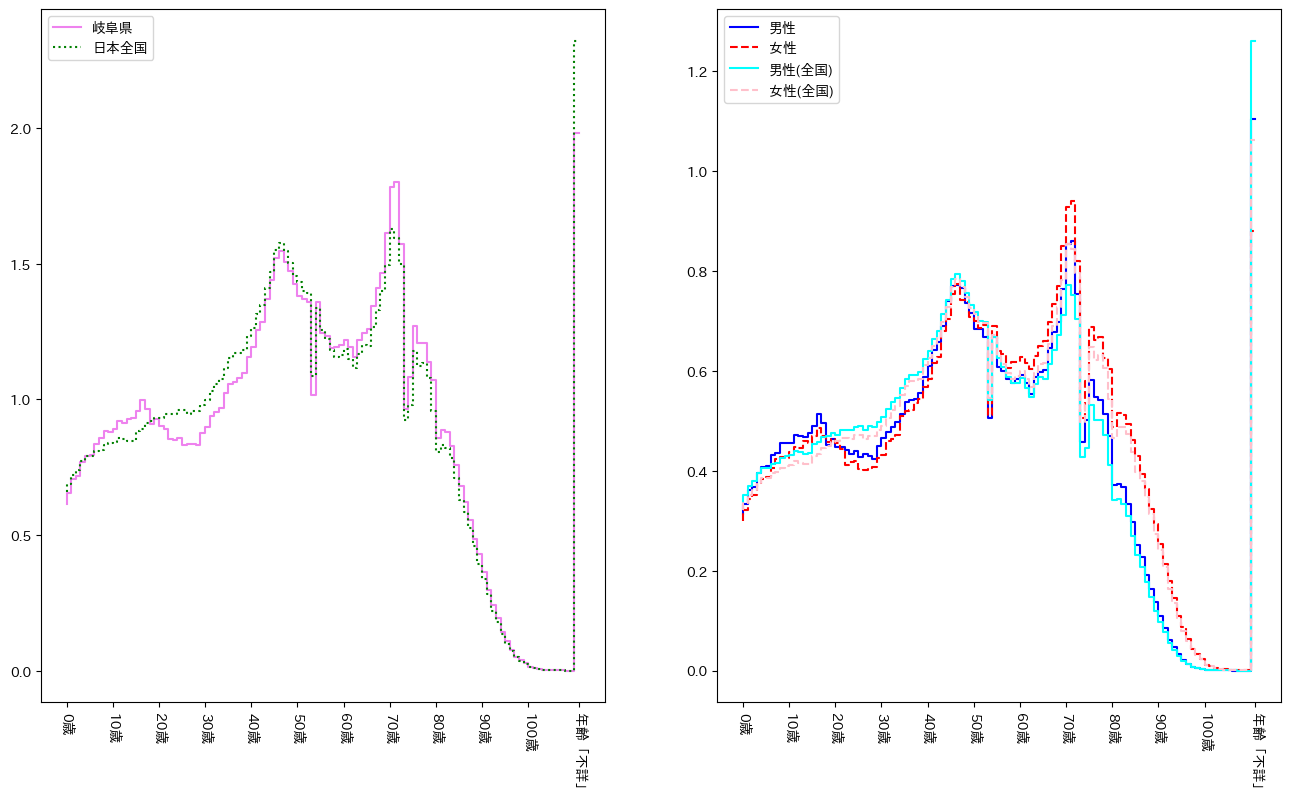

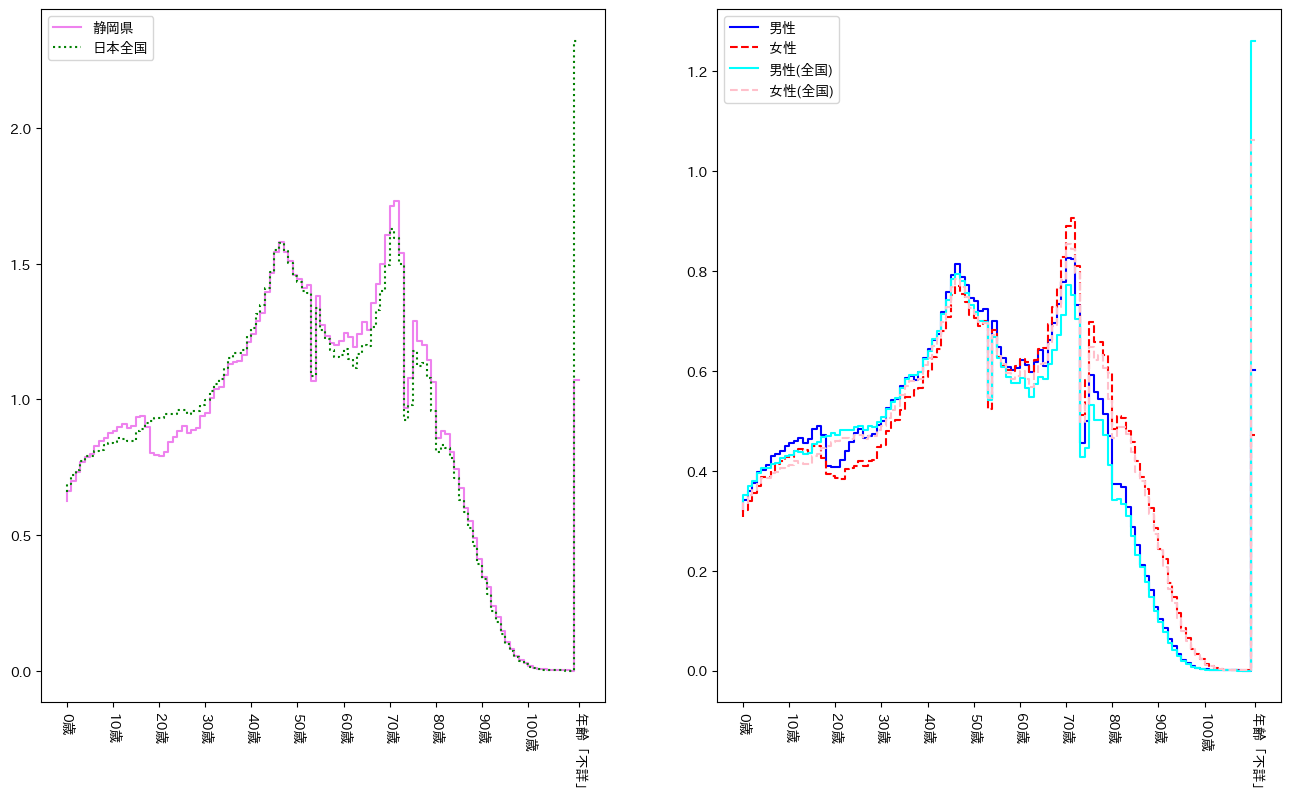

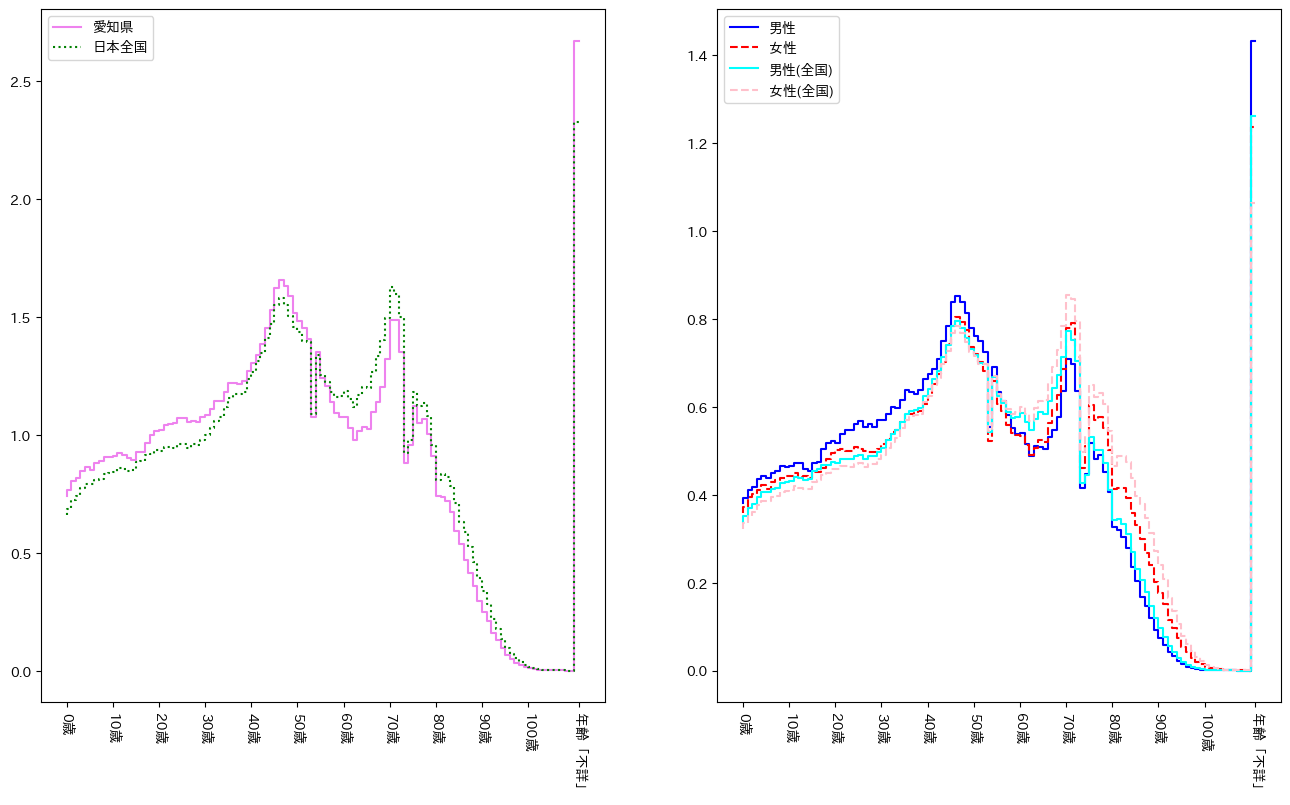

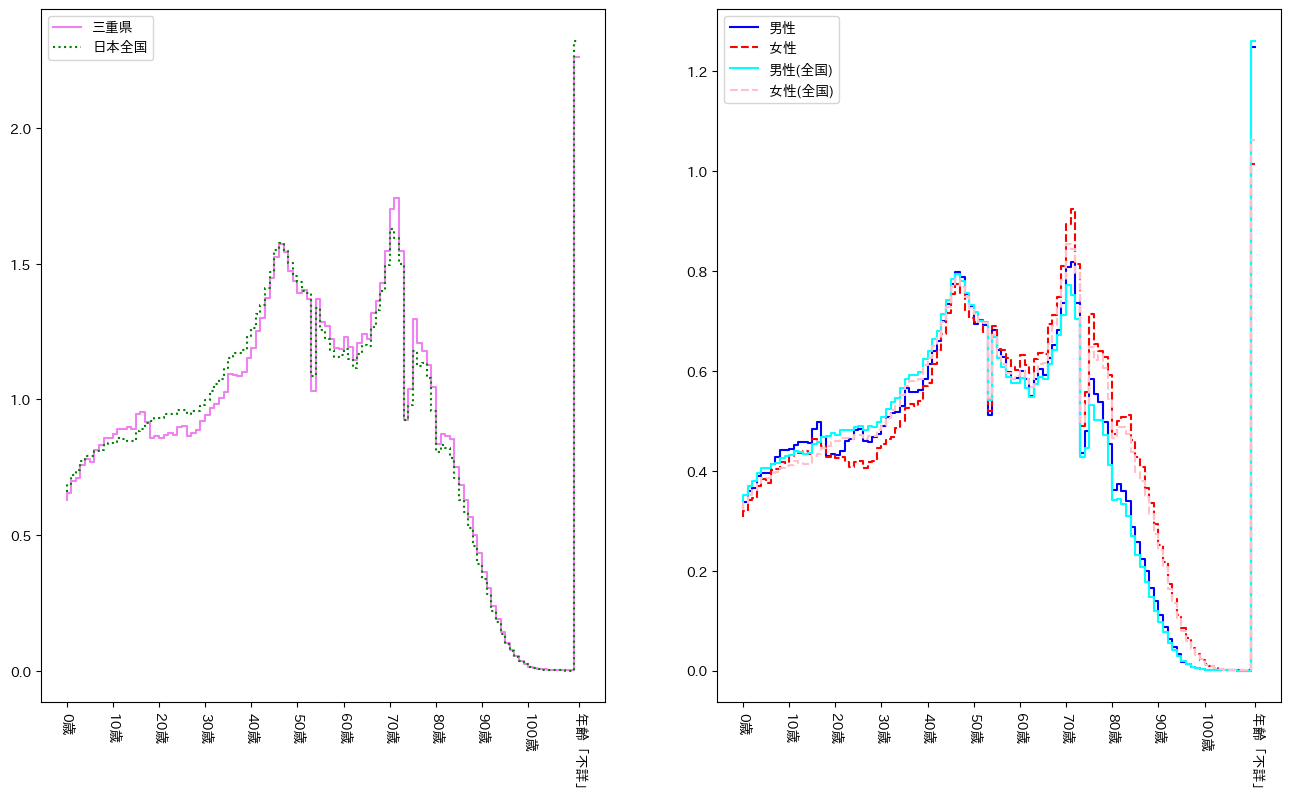

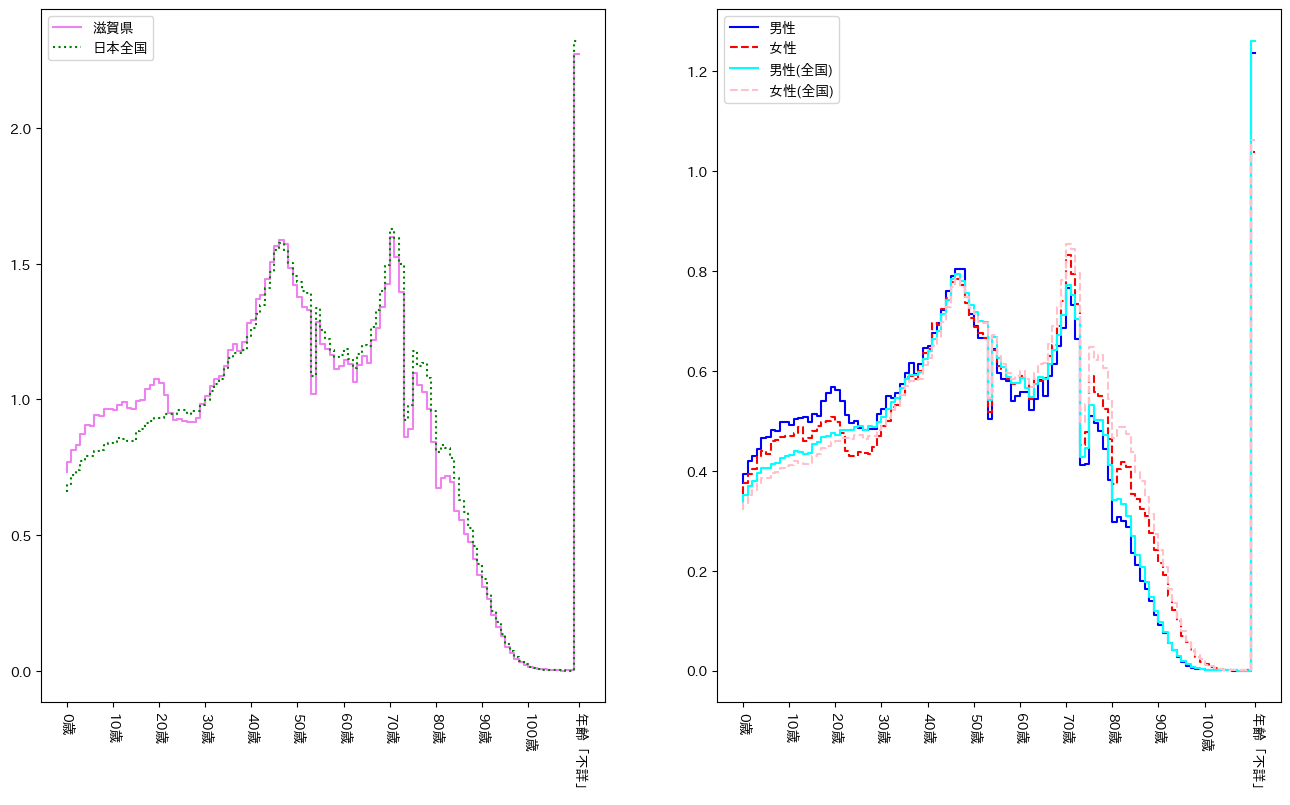

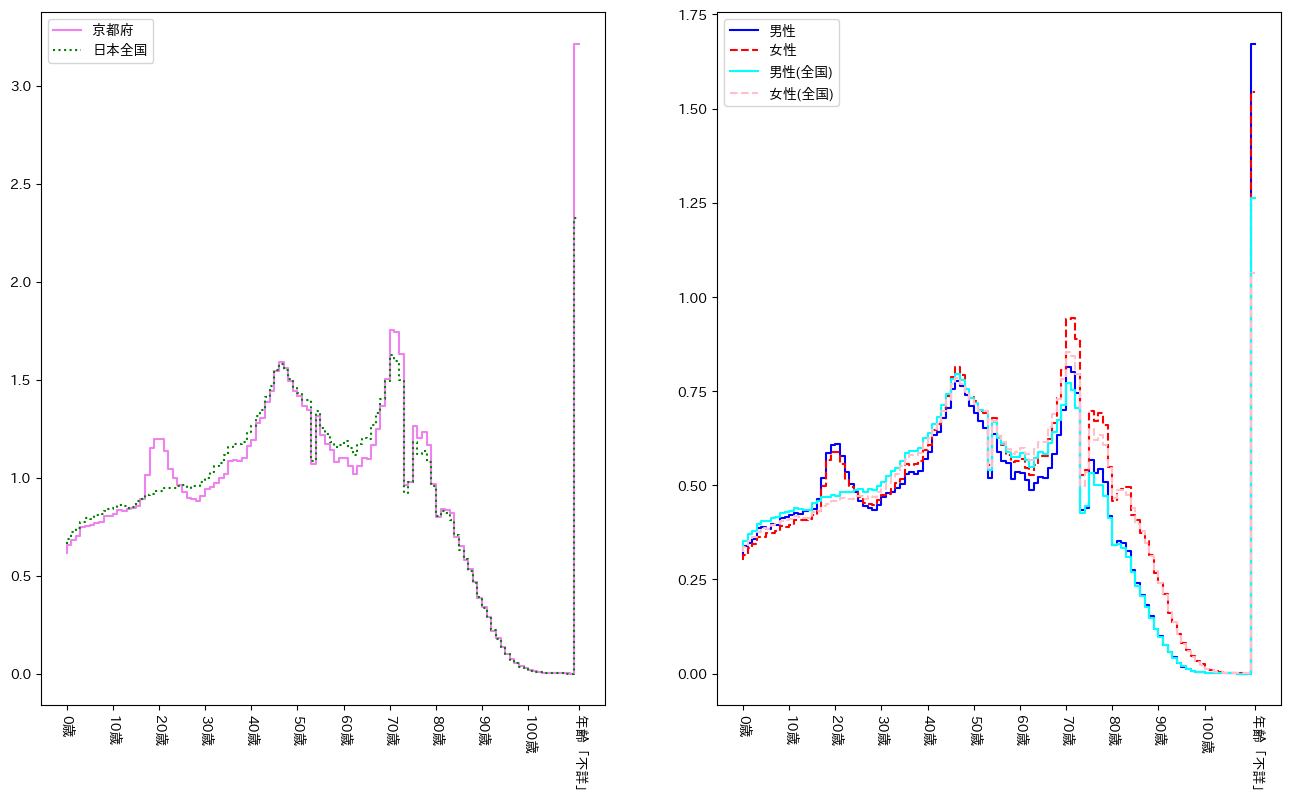

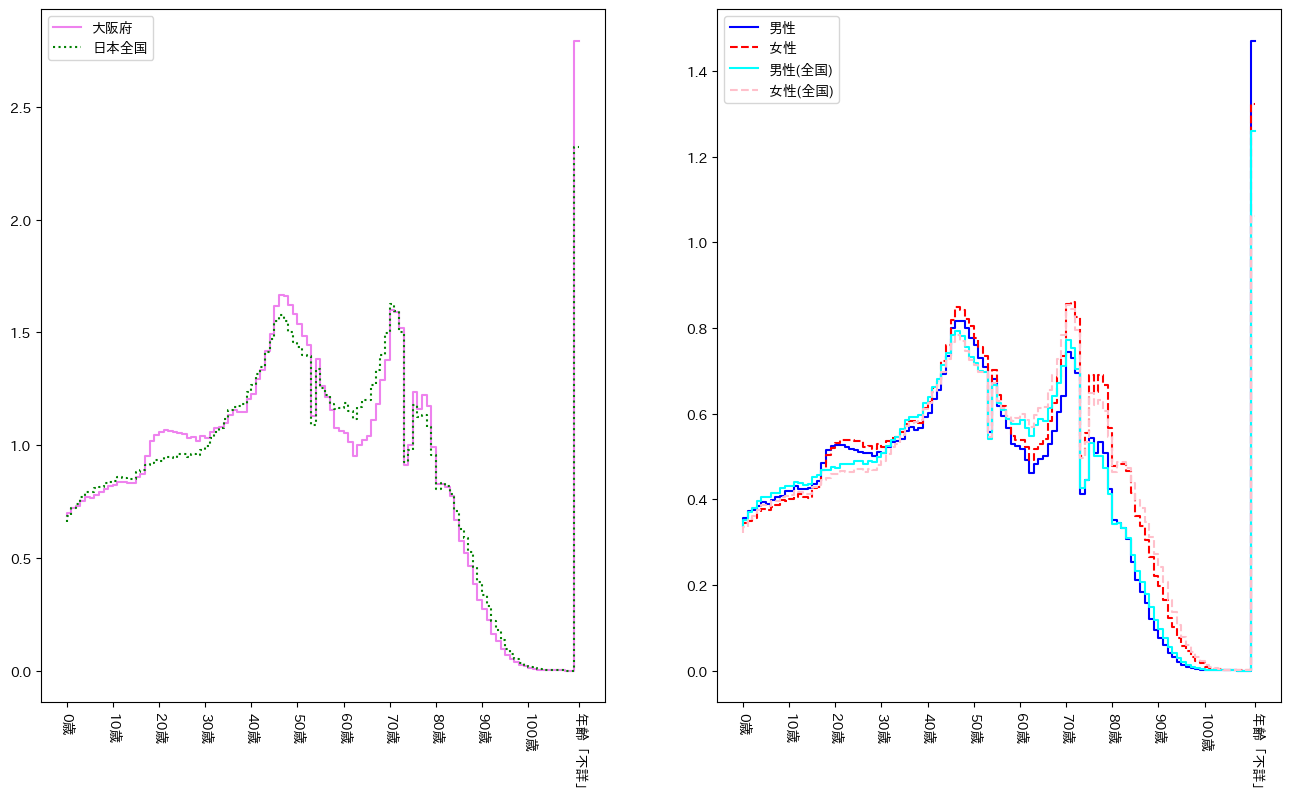

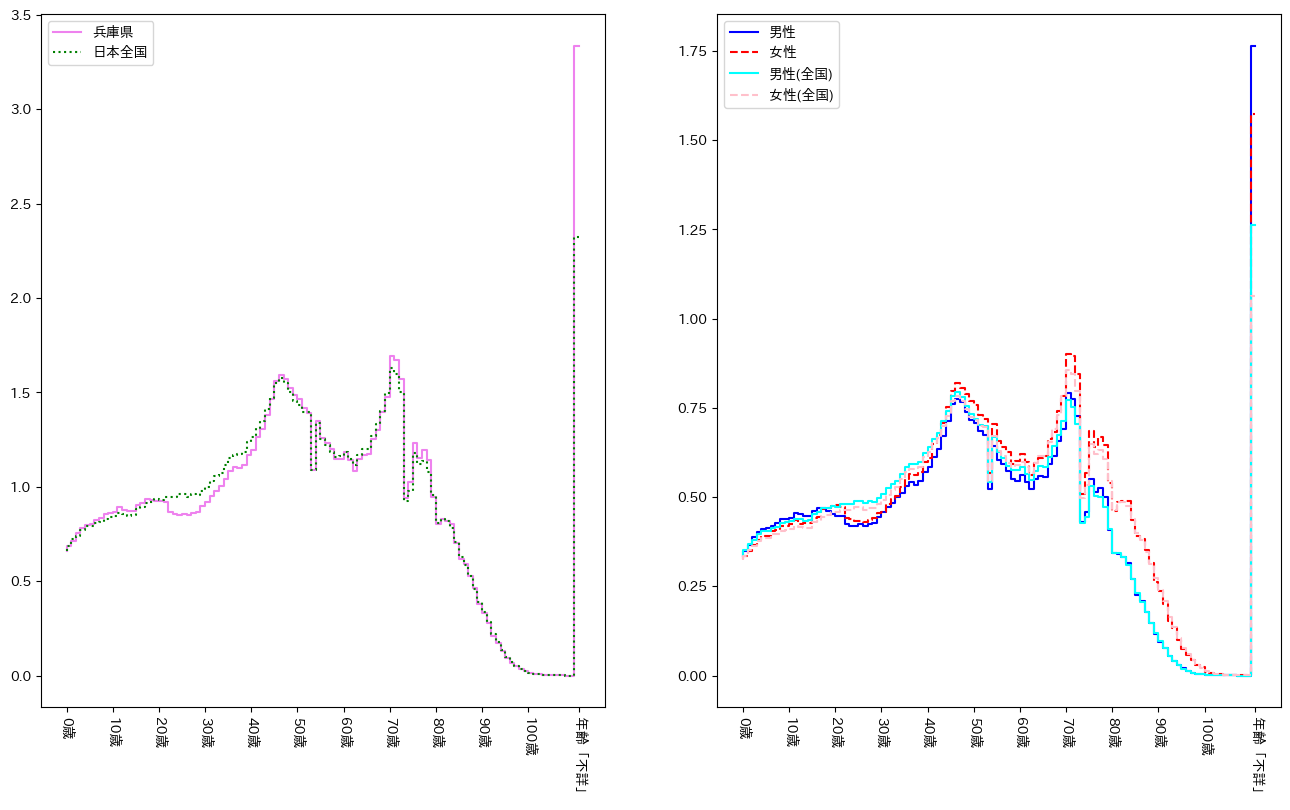

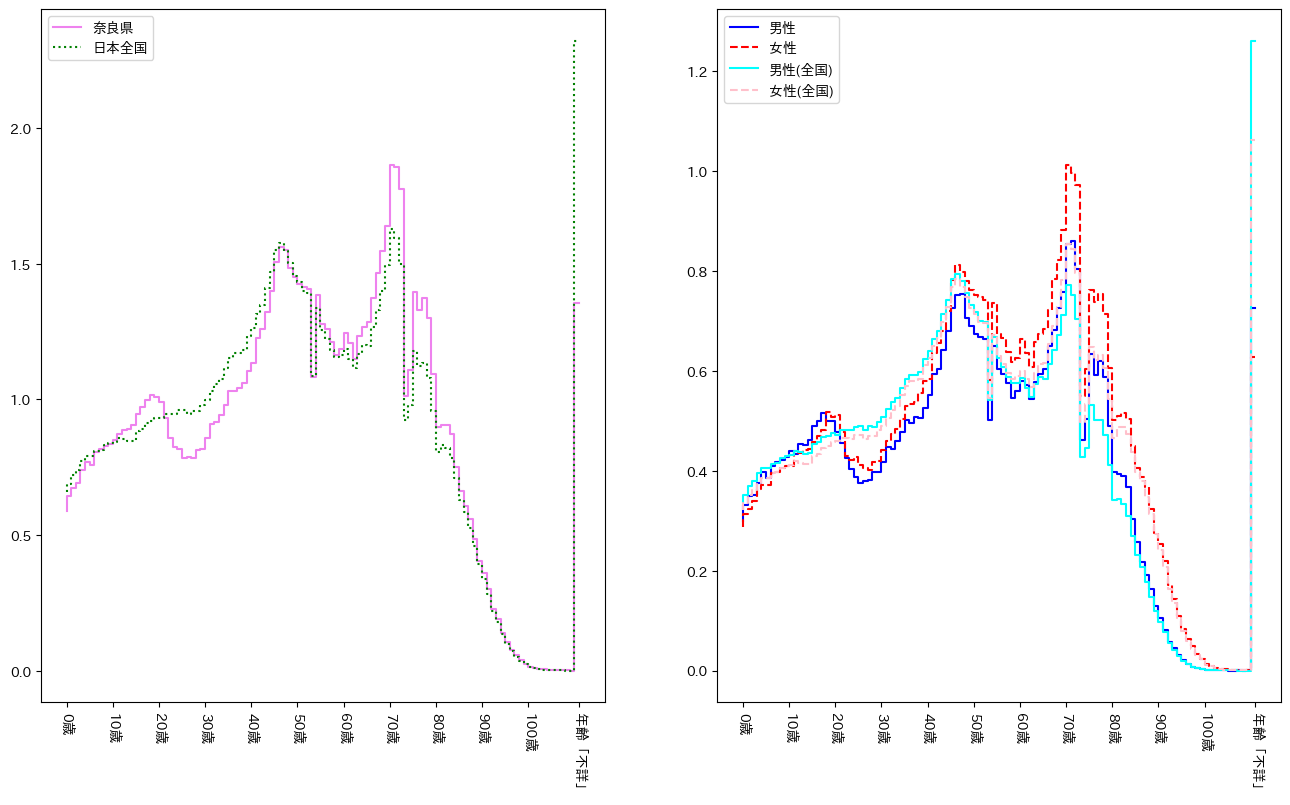

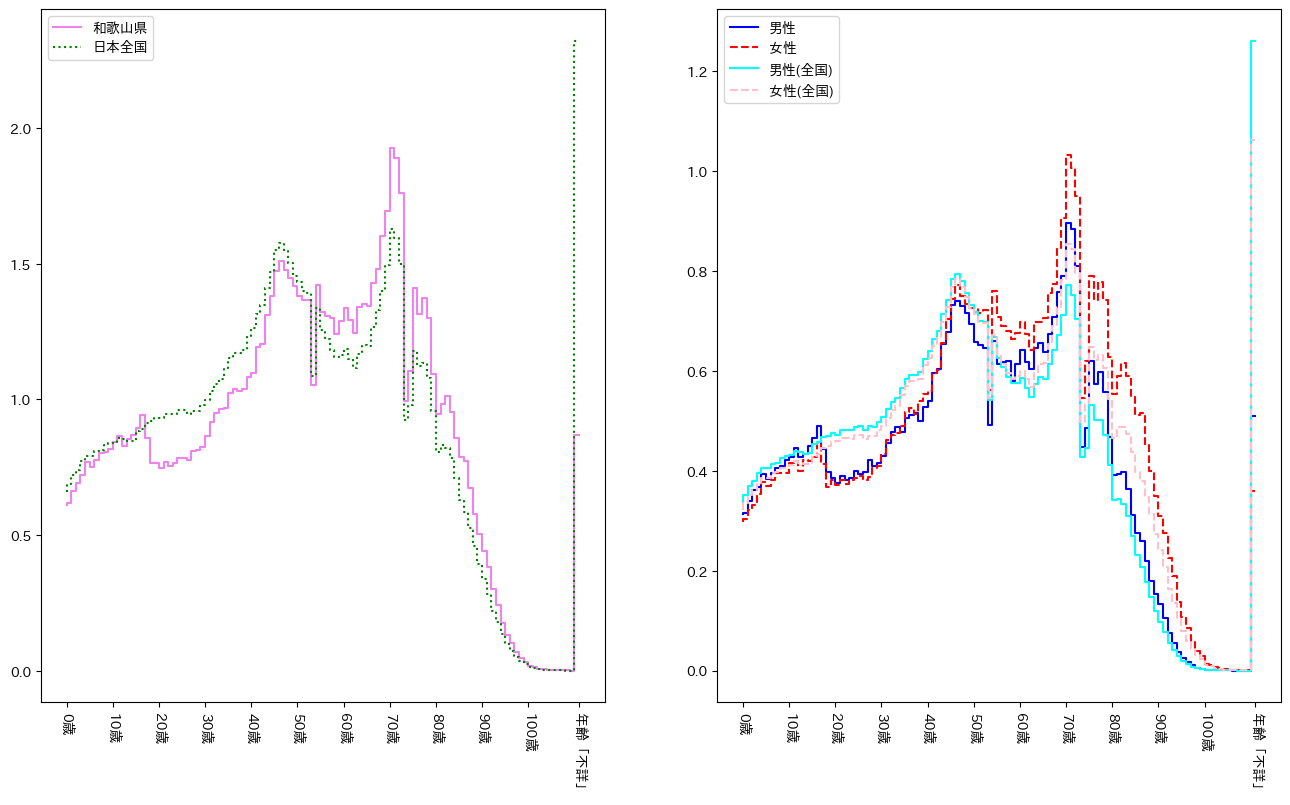

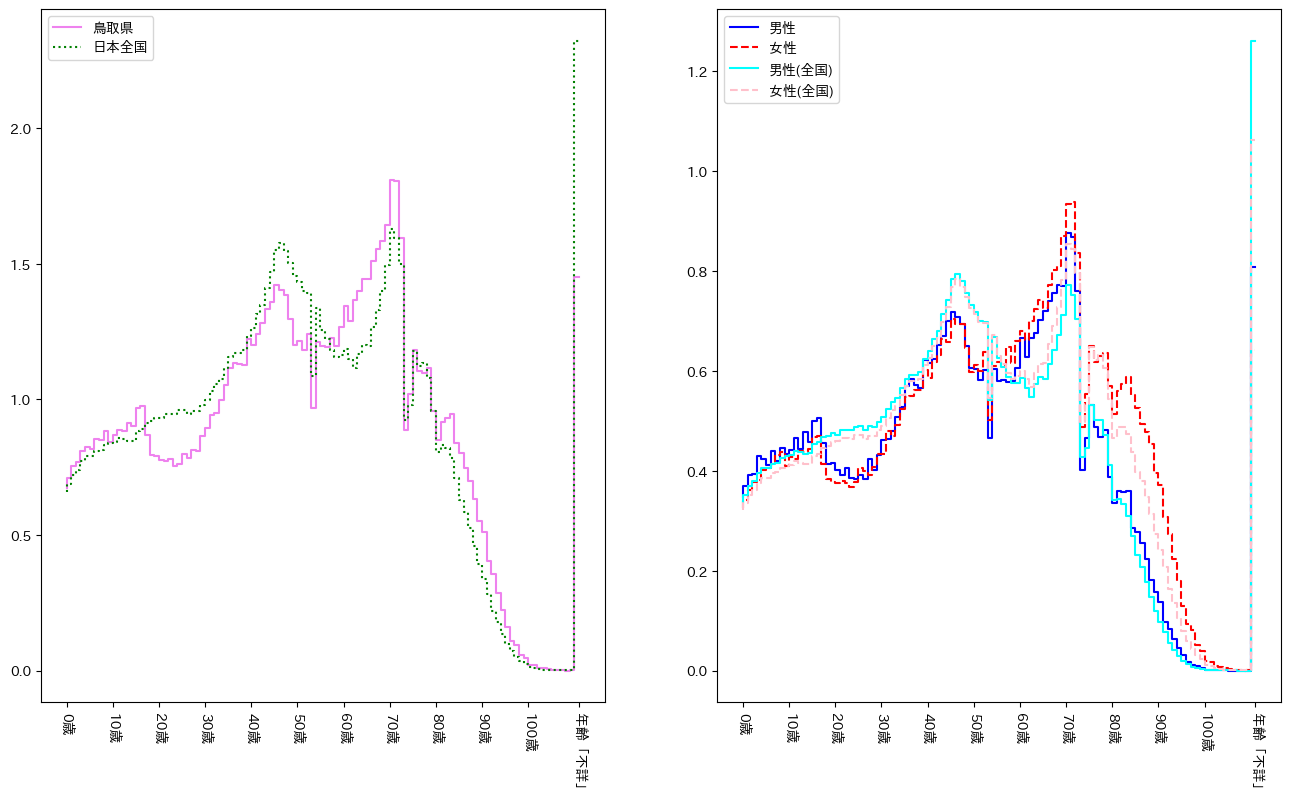

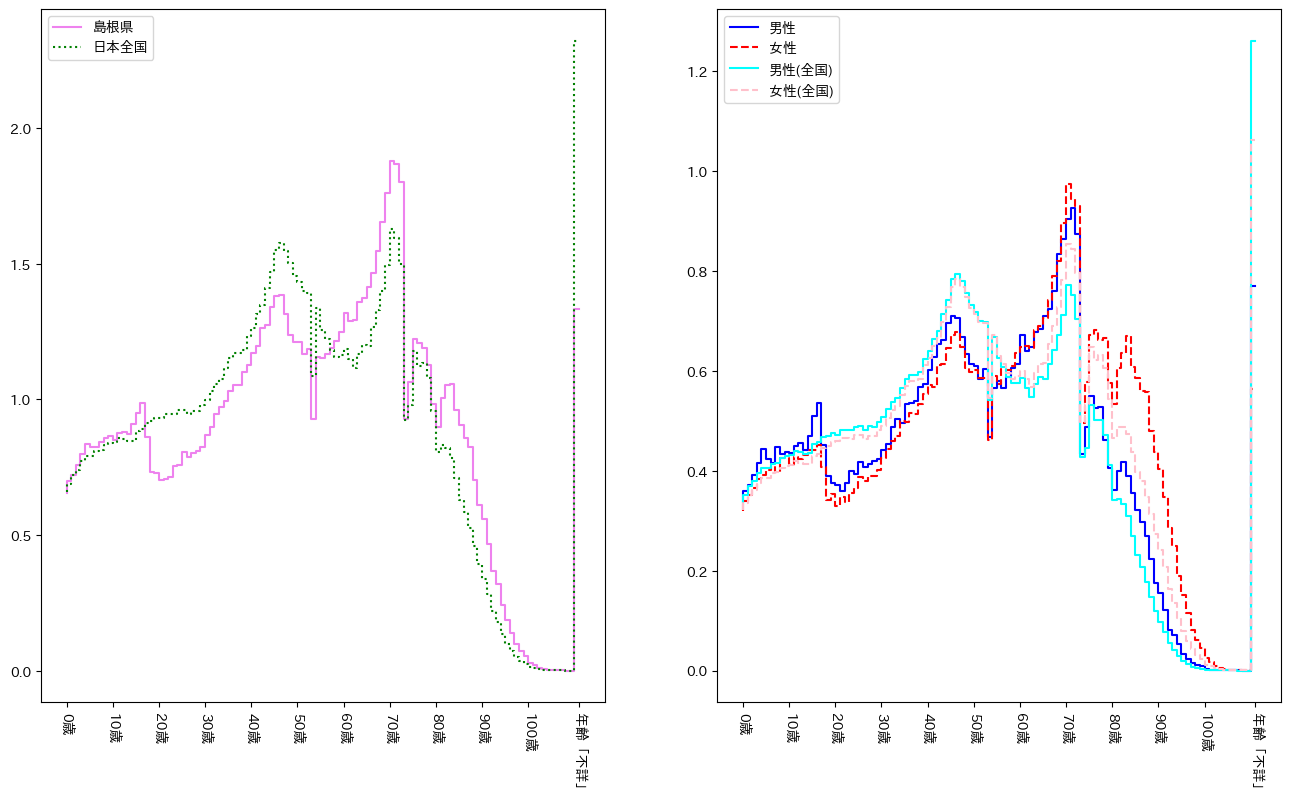

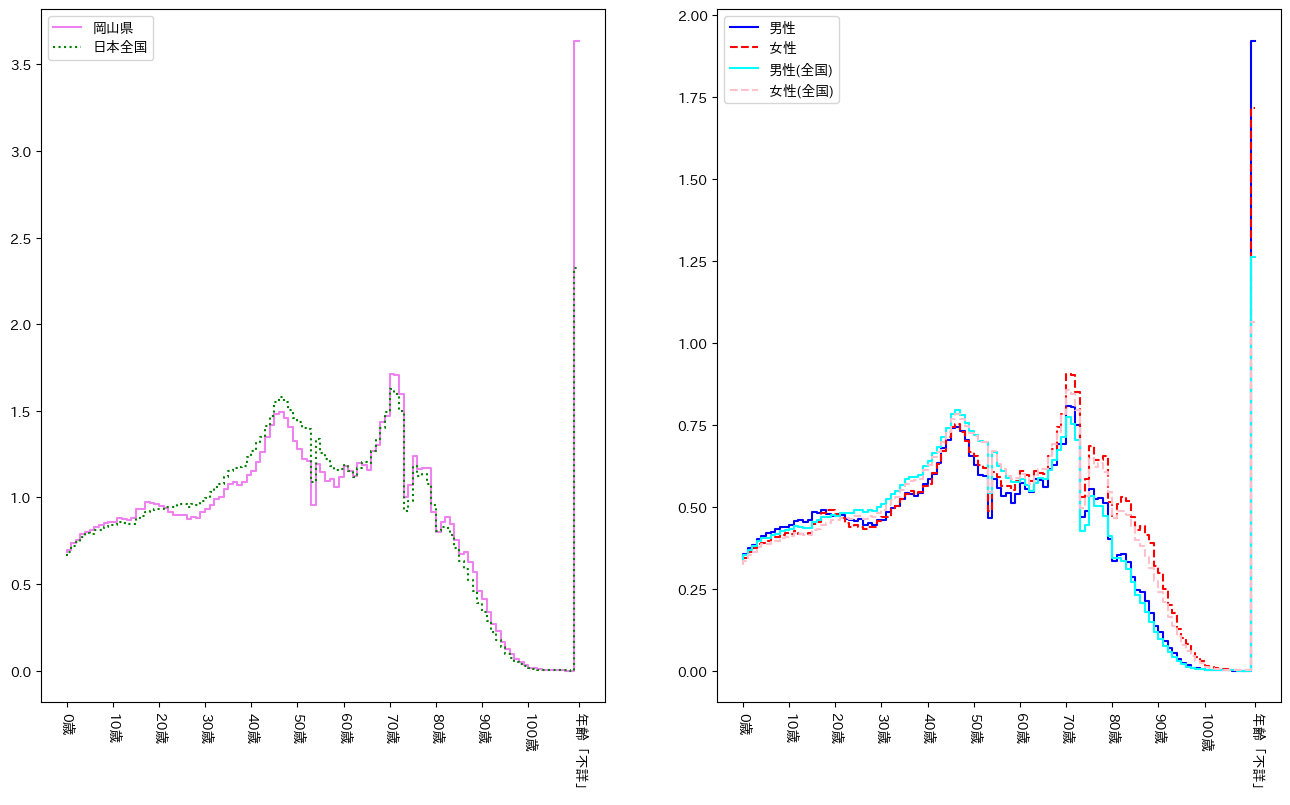

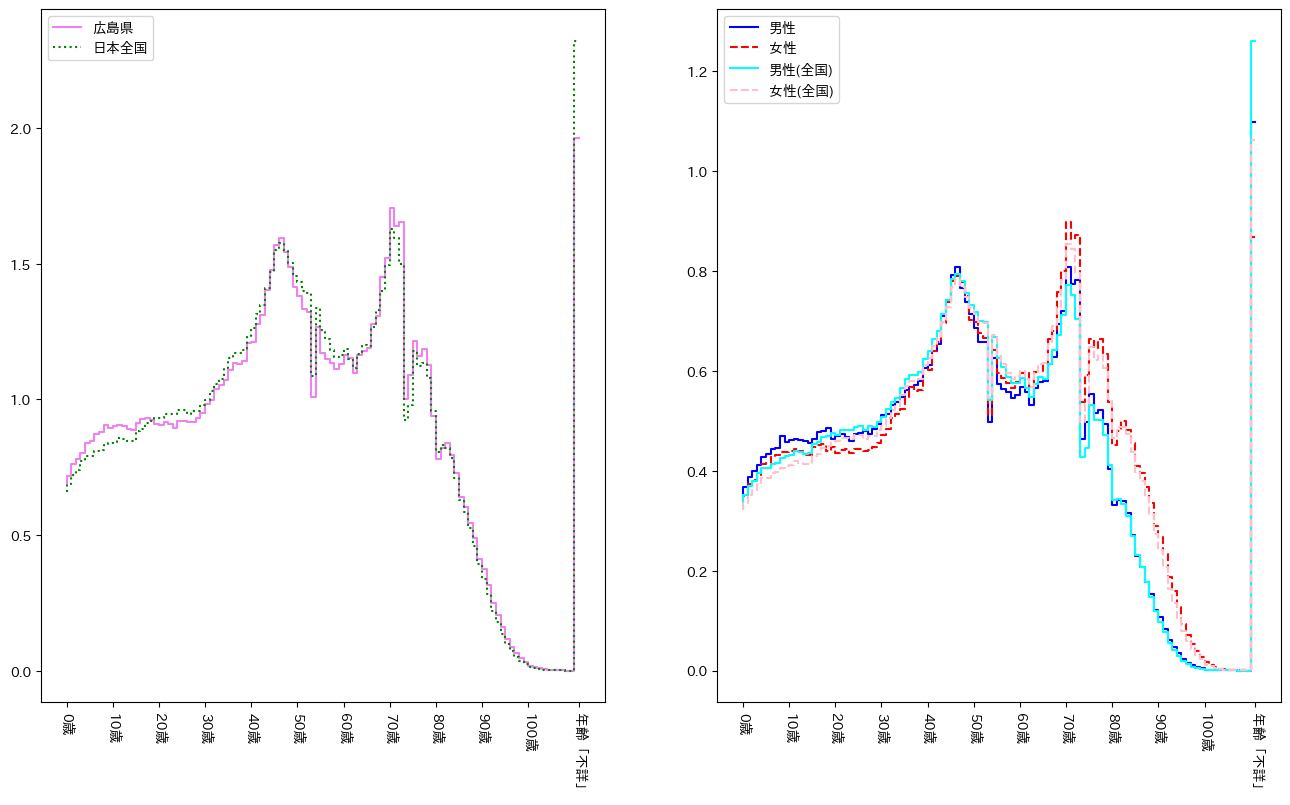

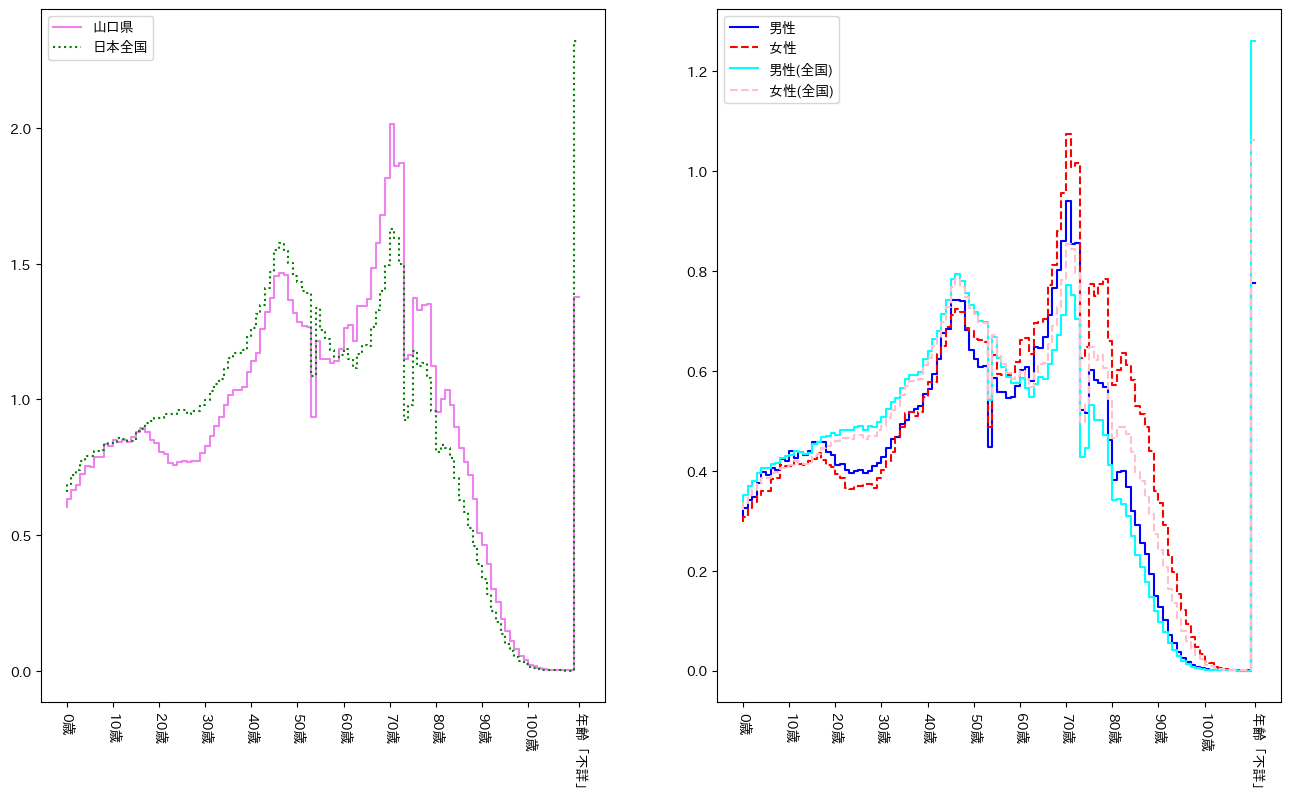

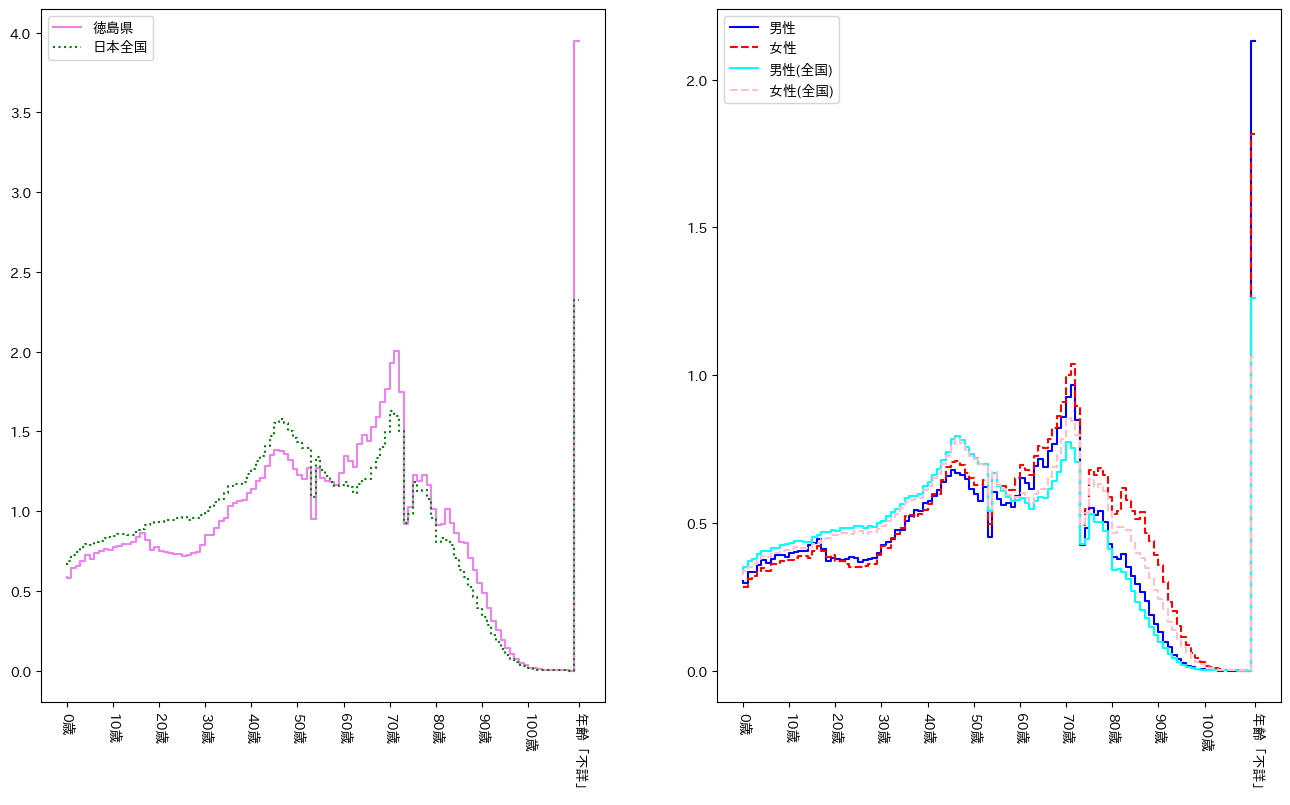

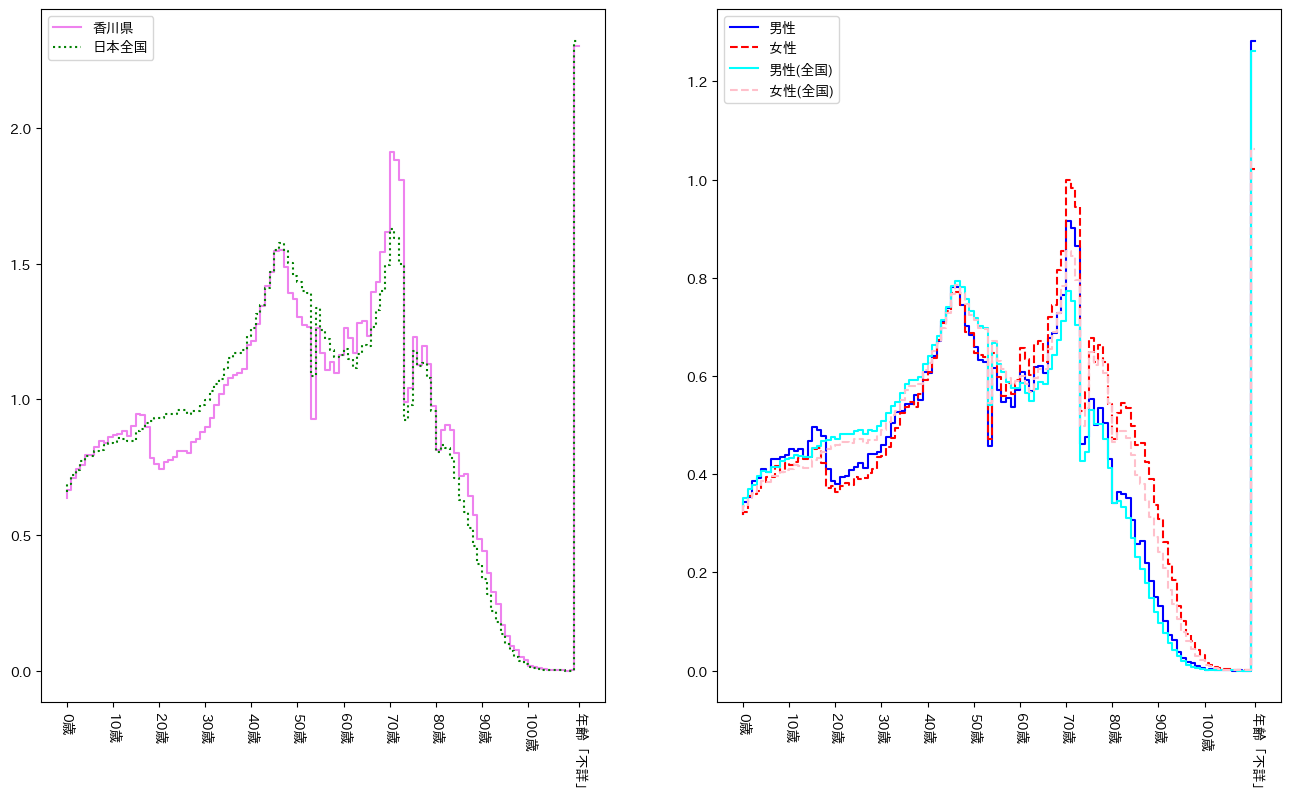

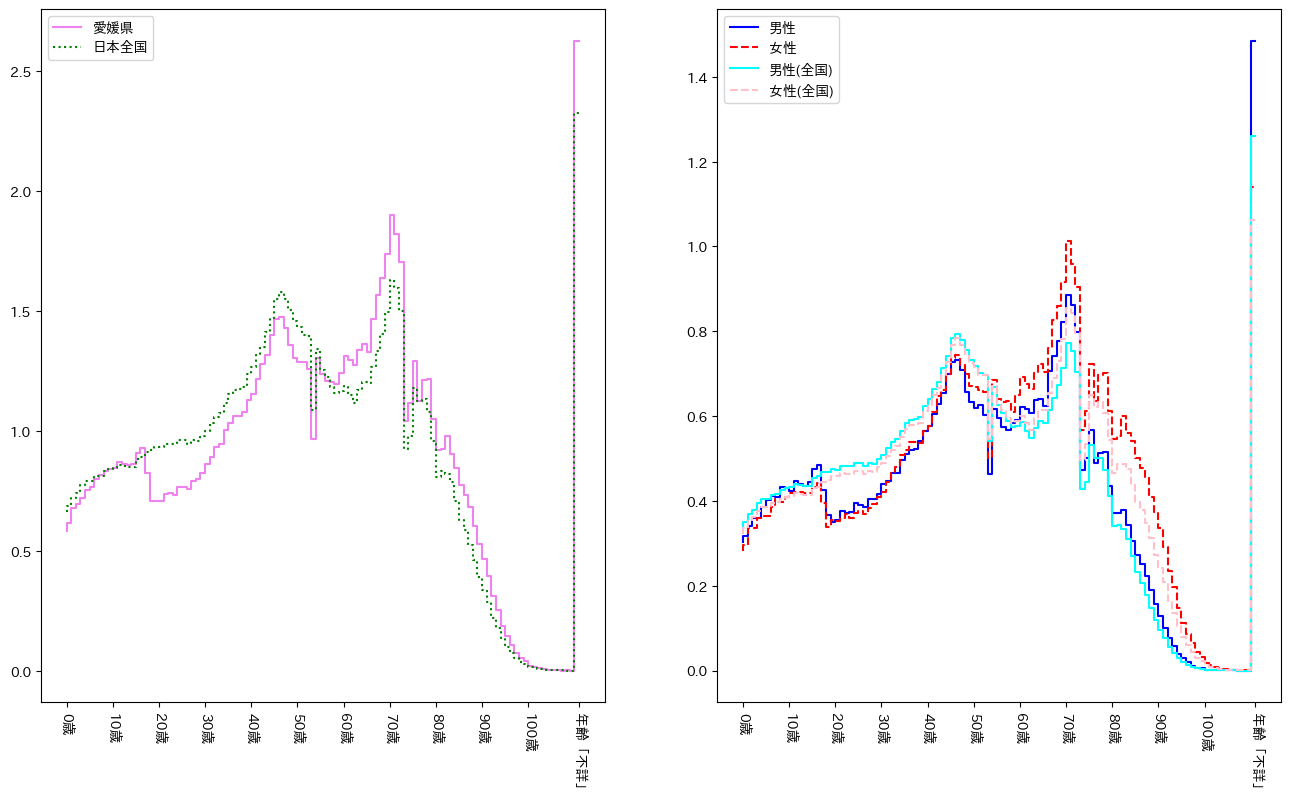

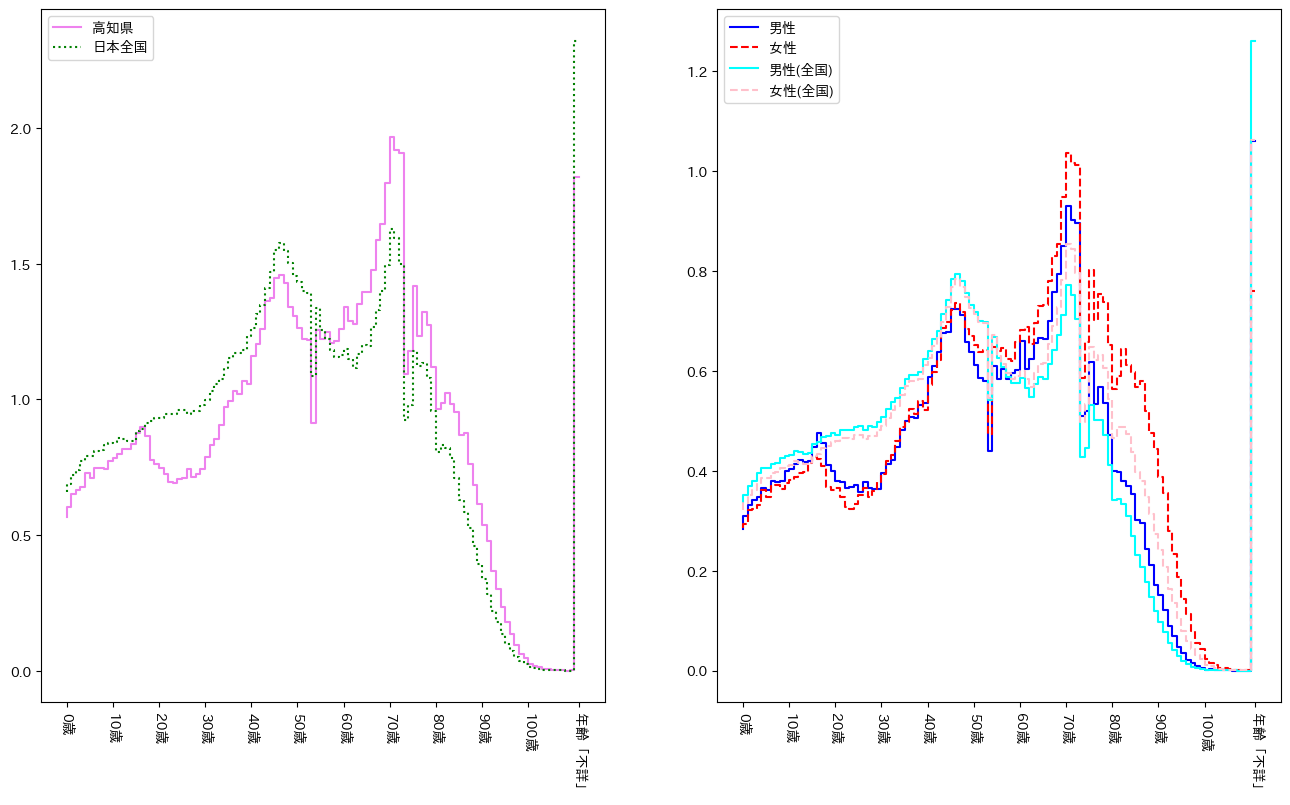

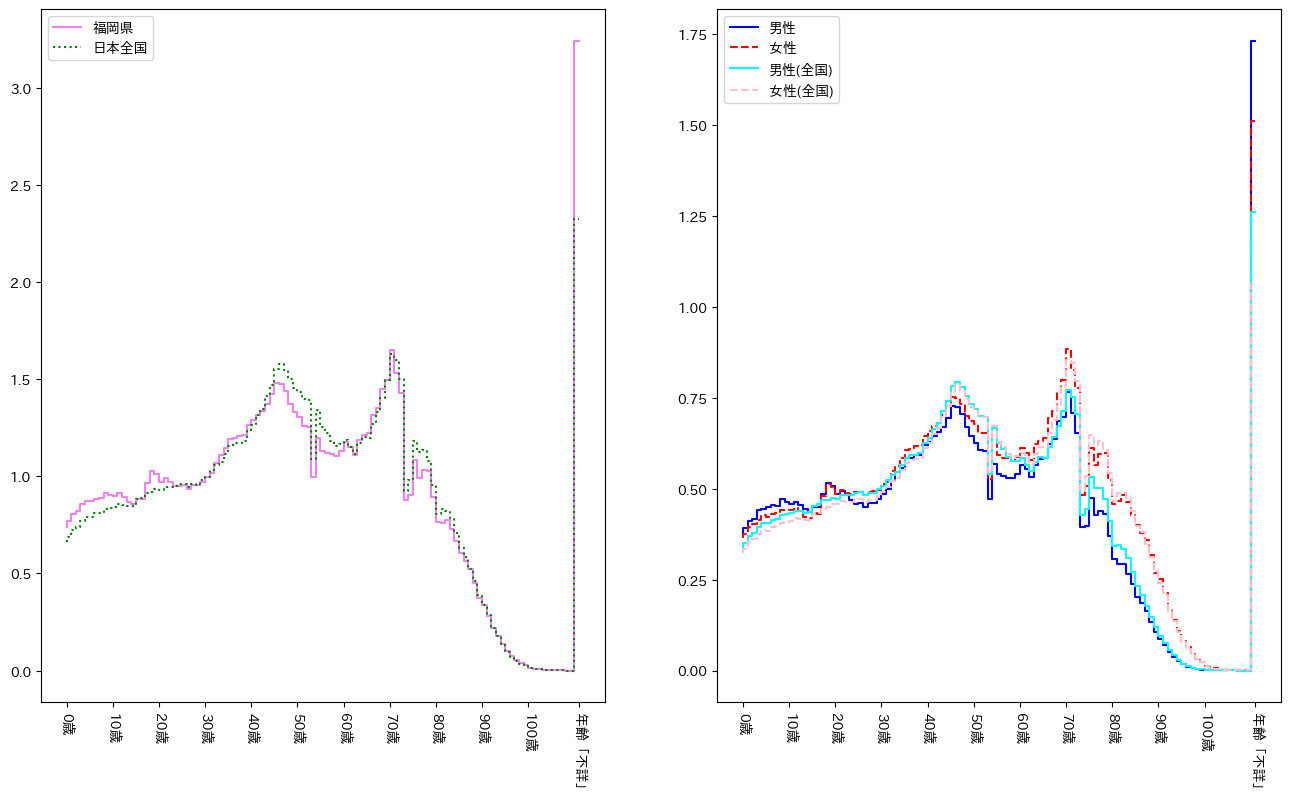

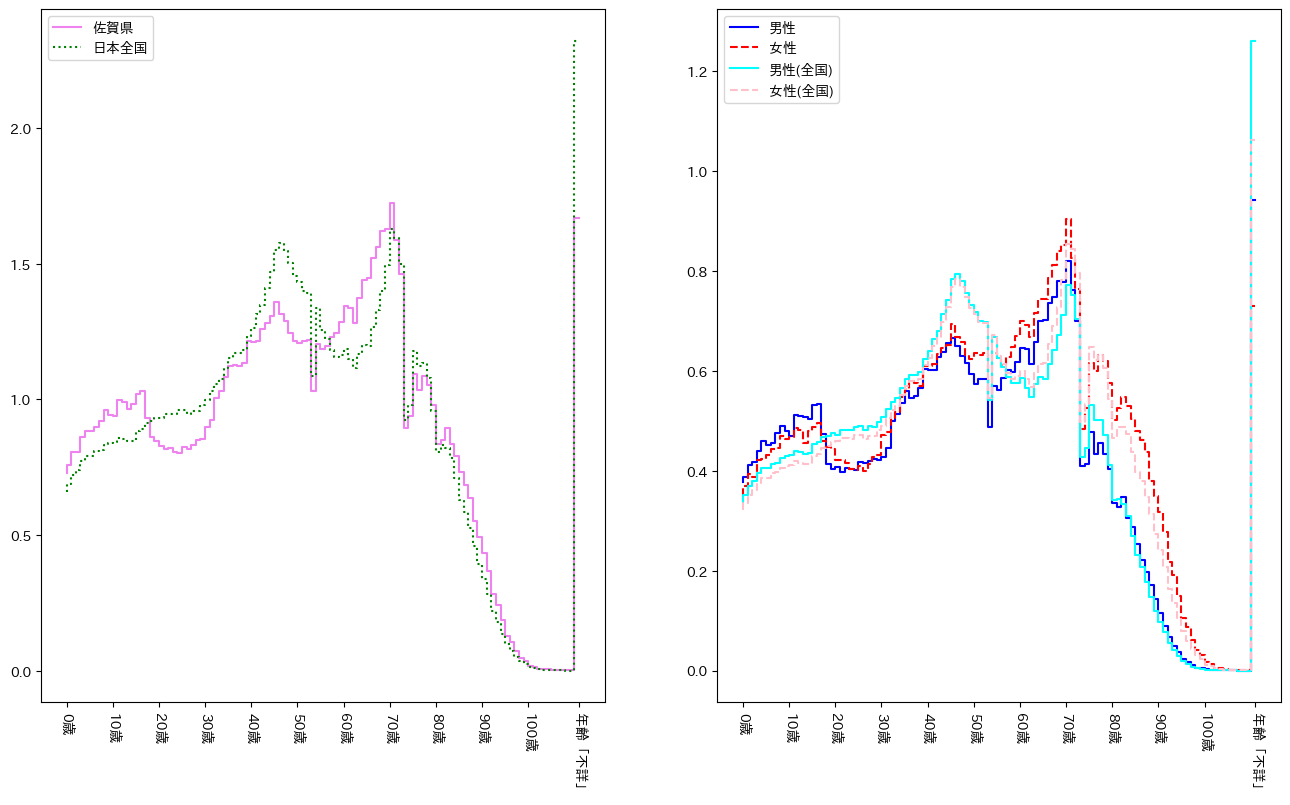

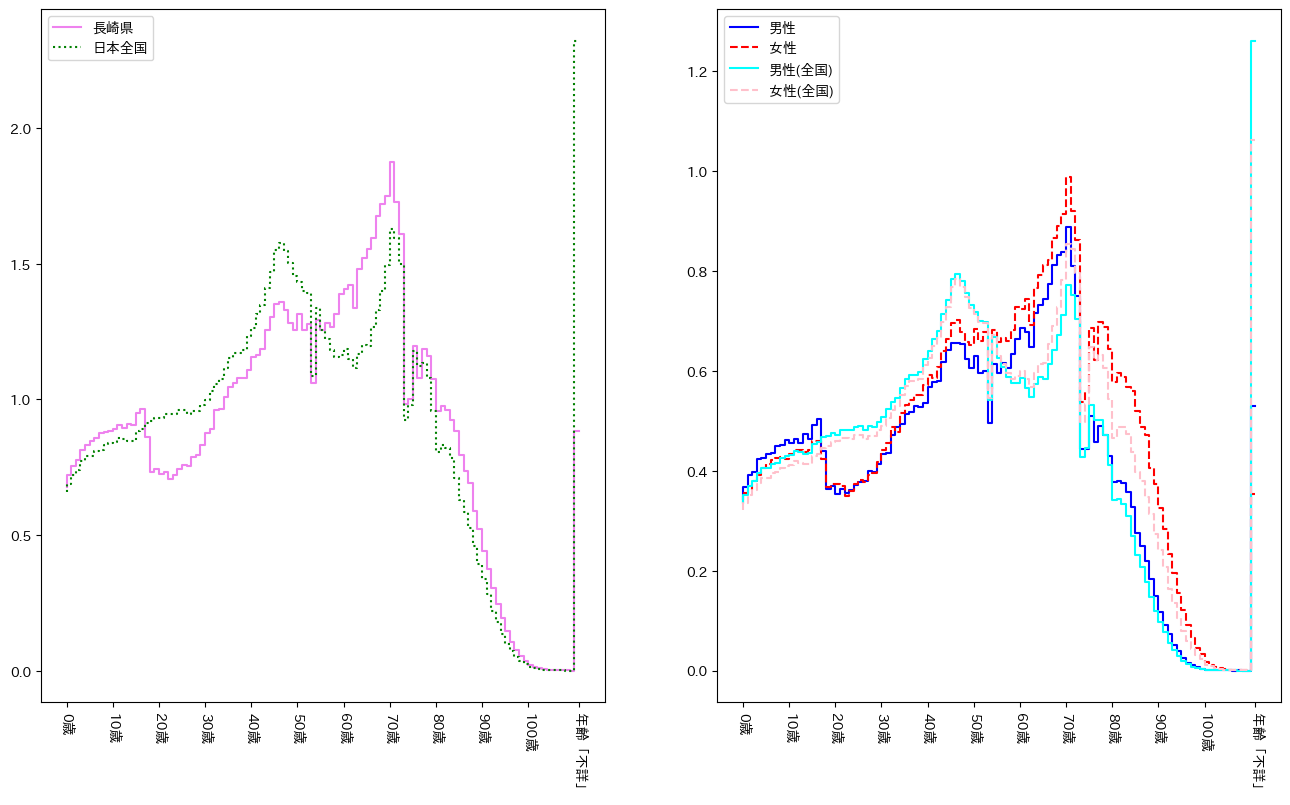

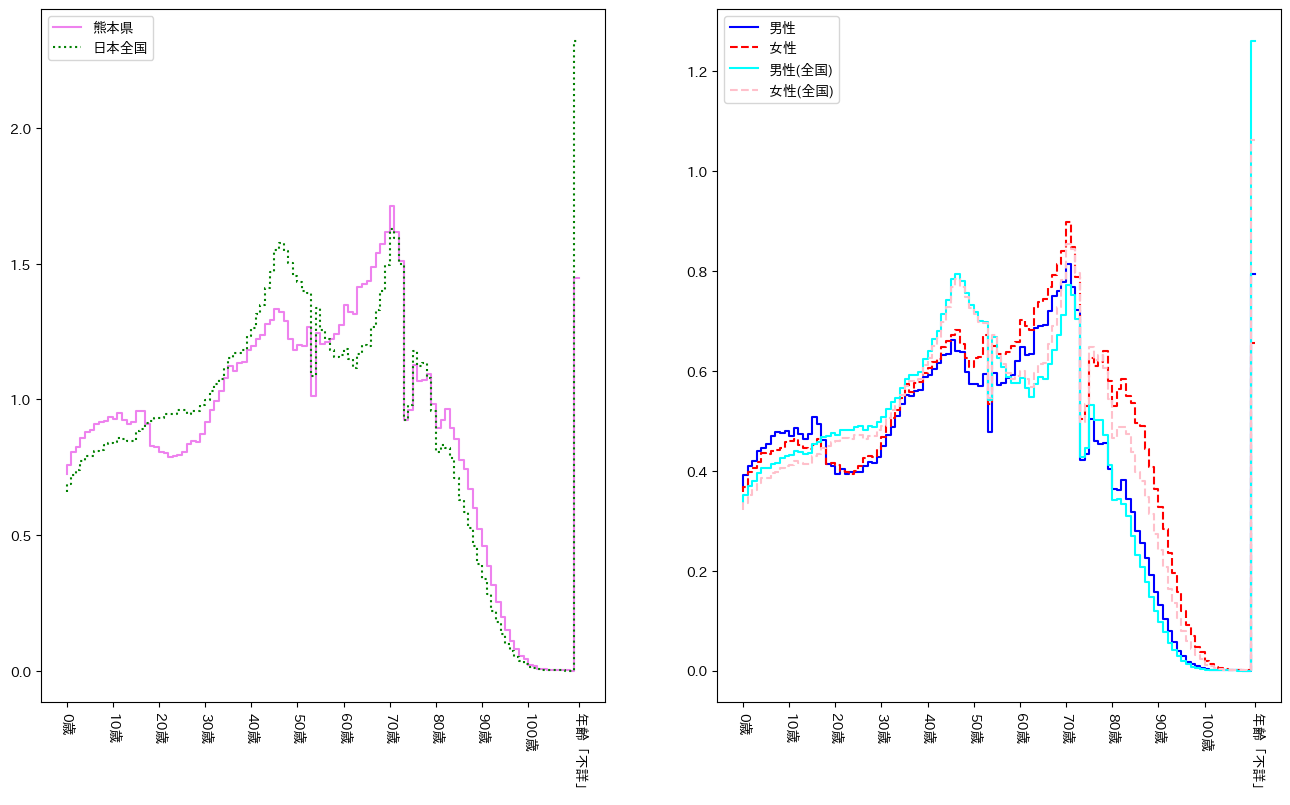

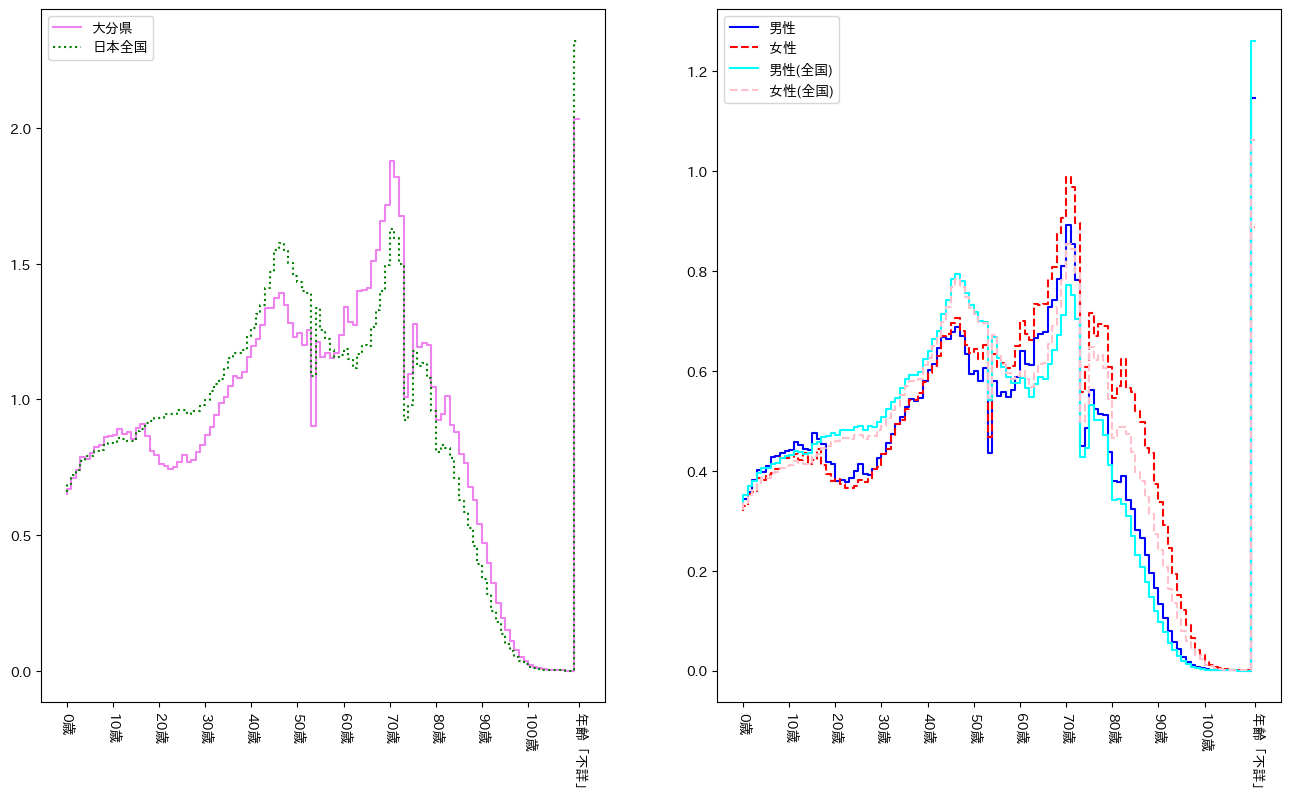

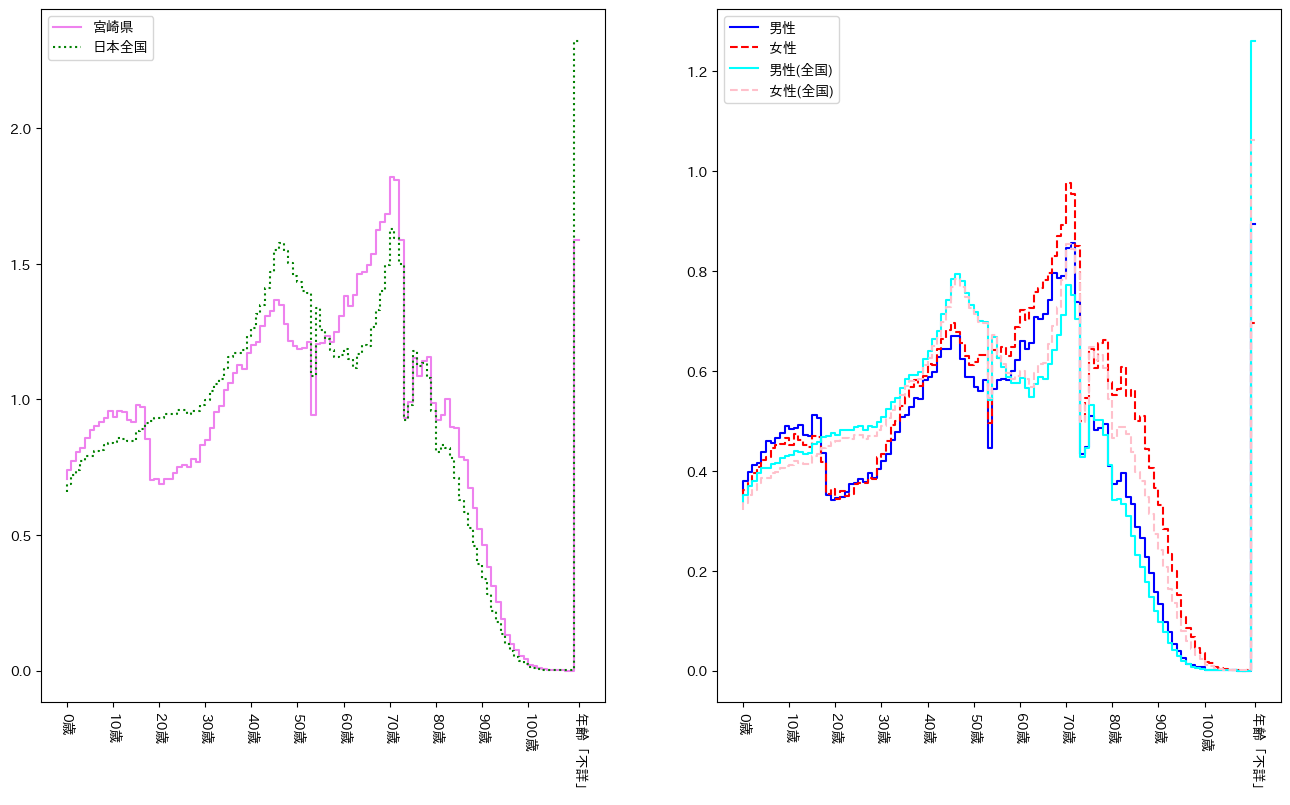

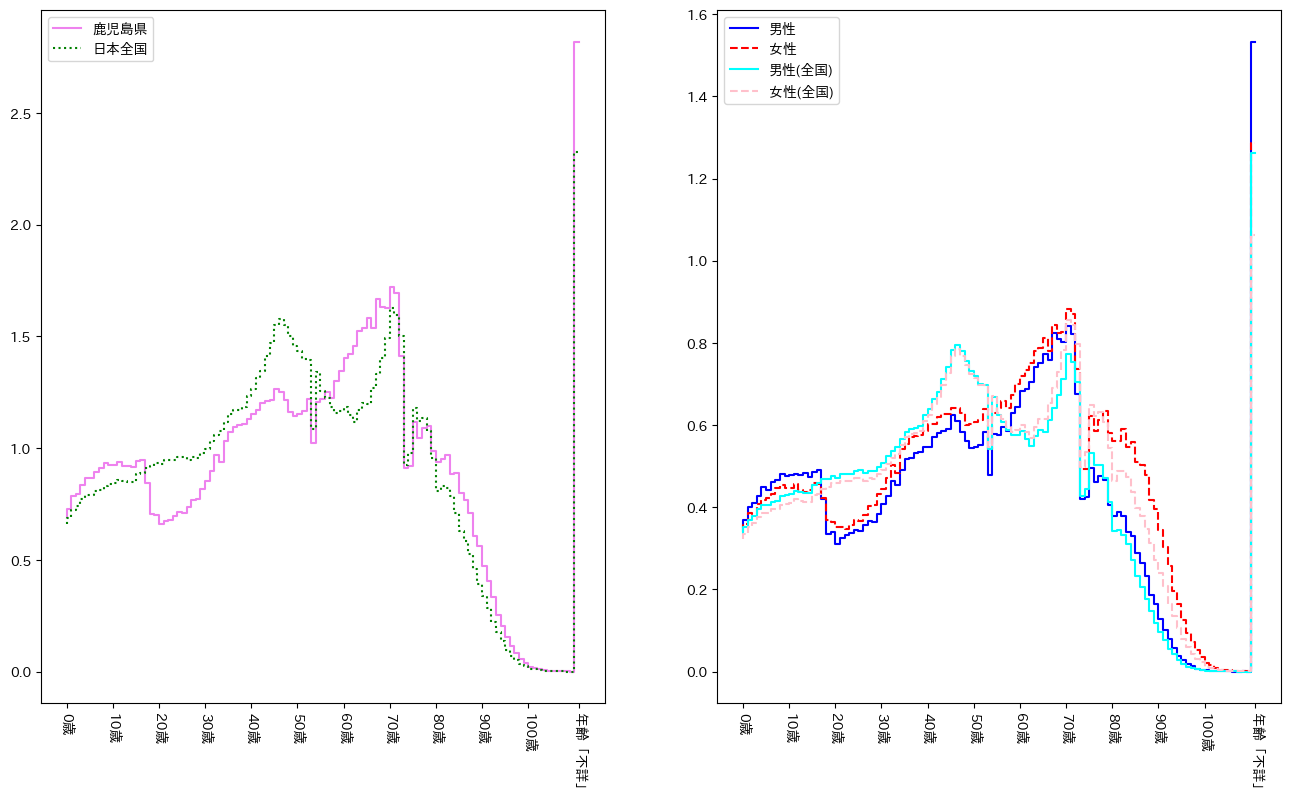

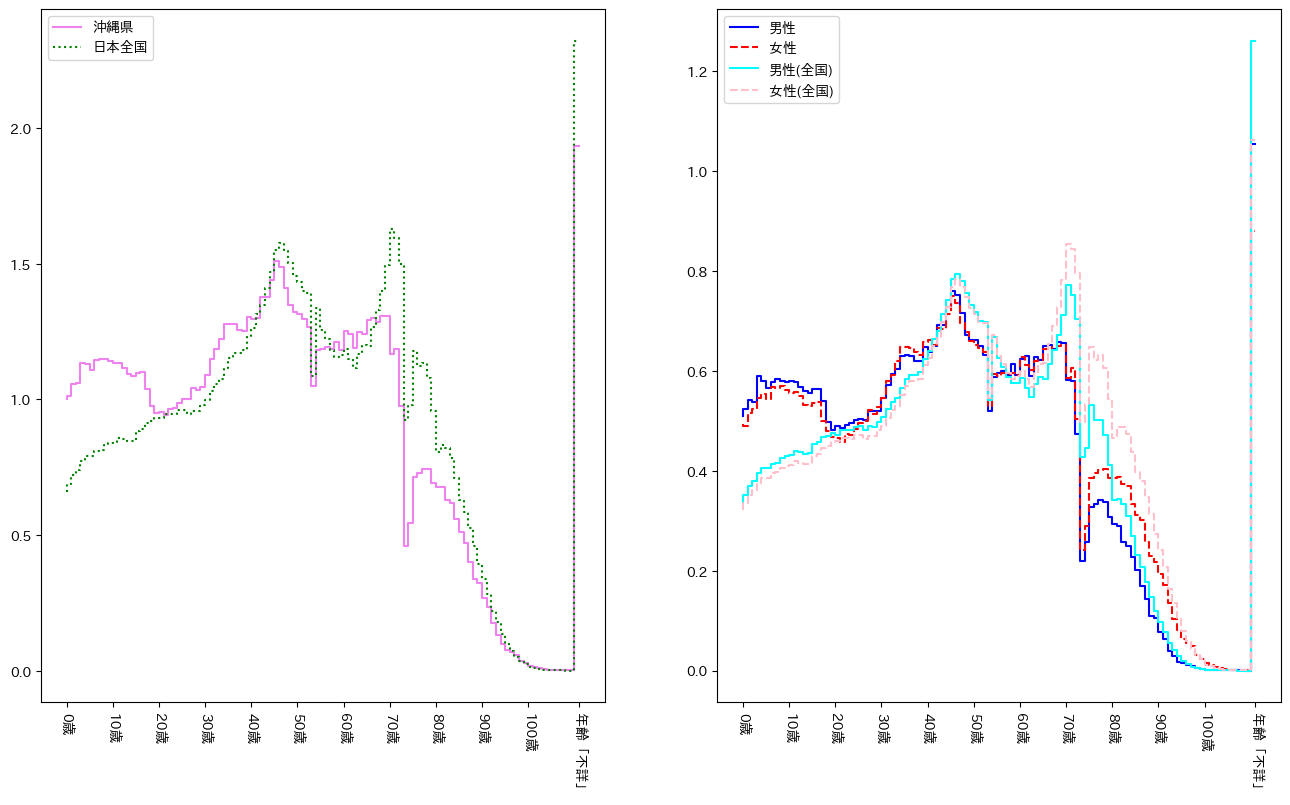

In [6]:
for pref in prefectures[1:]:
  draw_graph(pref)

人口データの最後の列は「'年齢「不詳」'」です。全国のデータでは約2％の人口がこのカテゴリに入っています。
各年齢に割り振れば0.02%程度の誤差となるわけですが、意外に多いなという感じです。
Wikipediaのグラフは2005年のデータを元にしているようですので、ベビーブーマーのピークなどが並行移動しているのがわかります。

沖縄県のグラフを見ると、昭和20年以前生まれの人口が他の都道府県と比べ、目立って少なくなっています。沖縄の激戦のためでしょうか。

また、75〜80代以上では、人口年齢分布の男女差が大きくなっています。これも戦争の影響なのかもしれません。

これらの分布は大きく二つのグループに分けられるようです。一つは、14〜18歳ぐらいで始まる大きな落ち込みのあるパターン、もう一つは逆にこの年代での増加が見られるパターンです。要するに県外への進学による大きな人口の移動があるという事なのでしょう。　前者のパターンでは、50〜60の間に、全国平均の分布に近づくあるいは、増加するという傾向があるように見えます。大学進学率の世代による変化なのかもしれません。

愛知県は男性のみ、18〜50歳ぐらいで全国平均より大きくなっています。 某企業の存在の効果なのかと想像してしまいます。
石川県も18歳付近でのみ男性の割合が全国平均と有意に増加しています。　某有名高校の存在が影響しているのでしょうか。宮城県も同様の年齢分布の全国との違いがありますね。